## Imports and various plotting utilities

This notebook uses [degas](https://github.com/williamgilpin/degas) for stylistic modifications only. The code is not necessary to run the notebook.


In [0]:
## Activate for dark plots
# DARK = True
DARK = False

## Activate to save figures
# SAVEFIG = True
SAVEFIG = False

NOSAVEFIG = True


import sys
import os
import json
import matplotlib.pyplot as plt


import seaborn as sns
sns.set_style()
import pandas as pd

# import dysts
from dysts.datasets import *
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

import degas as dg
dg.set_style()

FIGPATH = "../private_writing_forecast/fig_resources/"
if DARK:
    plt.style.use("dark_background")
    FIGPATH += "dark_"
    fg_color = (1, 1, 1)
    bg_color = (0, 0, 0)
    opacity_default = 0.5
else:
    fg_color = (0, 0, 0)
    bg_color = (1, 1, 1)
    opacity_default = 1.0
# if not SAVEFIG:
#     dg.better_savefig = lambda *args, **kwargs: None

    
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Plotting preliminaries
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
# matplotlib.rc('text', usetex='false') 

pastel_rainbow = np.array([
    [0.17254902, 0.45098039, 0.69803922],
    [0.19607843, 0.47843137, 0.5372549 ],
    [0.372549, 0.596078, 1],
    [0.16862745, 0.20392157, 0.48627451],
    [0.24705882, 0.58039216, 0.42745098],
    [0.65882353, 0.75294118, 0.86666667],
    [0.63921569, 0.85490196, 0.52156863],
    [0.72941176, 0.67843137, 0.83921569],
    [0.53333333, 0.62352941, 0.47843137],
    [0.64705882, 0.70588235, 0.52156863],
    [0.64313725, 0.14117647, 0.48627451],
    [0.92941176, 0.61568627, 0.24705882],
    [0.86666667, 0.23137255, 0.20784314],
    [1.0, 0.3882, 0.2784]
])

## Red strength sorting
sort_inds = np.argsort(pastel_rainbow[:, 0] / pastel_rainbow[:, -1])
sort_inds = np.argsort(pastel_rainbow[:, 0] / (pastel_rainbow[:, 2] + 0.5 * pastel_rainbow[:, 1]))
pastel_rainbow = pastel_rainbow[sort_inds]


pastel_rainbow = dg.color_sort(pastel_rainbow)


import re
def rename_models(ndict):
    """
    A custom set of names for the models
    """
    out = {}
    for key in ndict.keys():
        new_key = key.replace("Model", "")

        ## Add space whenever a lowercase letter is followed by an uppercase letter
        new_key = re.sub(r'([a-z])([A-Z])', r'\1 \2', new_key)
        if new_key == "NHi TS":
            new_key = 'NHiTS'
        if new_key == "RNN":
            new_key = "LSTM"
        if new_key == "Block RNN":
            new_key = "RNN"
        if new_key == "XGB":
            new_key = "XGBoost"
        if new_key == "ESN":
            new_key = "Echo State"
        if new_key == "ExponentialSmoothing":
            new_key = "Exp. Smooth."
        if new_key == "Kalman Forecaster":
            new_key = "Kalman"
        if new_key == "Linear Regression":
            new_key = "Linear"
        if new_key in ["NODE", "n ODE"]:
            new_key = "neural ODE"
        if new_key == "TCN":
            new_key = "Temporal ConvNet"
        if new_key in ["NVAR", "n VAR"]:
            new_key = "nonlin. VAR"

        out[new_key] = ndict[key]
    return out

## Multivariate benchmarks at fixed time horizon

+ Forecasting results in units of dominant timescale, rather than Lyapunov time

In [60]:
import os
import json
import gzip

GRANULARITY = 100

with gzip.open(
    os.getcwd()
    + "/results/results_neural_ode_multivariate.json.gz",
    "r",
) as file:
    all_results2 = json.load(file)

with gzip.open(
    os.getcwd()
    + "/results/results_test_multivariate__pts_per_period_100__periods_12.json.gz",
    "r",
) as file:
    all_results1 = json.load(file)

with open(os.getcwd() + "/results/results_esn_multivariate.json", "r") as file:
    all_results_esn = json.load(file)

with gzip.open(os.getcwd() + "/results/results_nvar_multivariate.json.gz", "r") as file:
    all_results_nvar = json.load(file)

all_scores = dict()
for key in all_results1.keys():
    if key not in all_results2.keys():
        continue
    all_scores[key] = dict()
    for model_name in all_results1[key].keys():
        if model_name == "values":
            continue
        all_scores[key][model_name] = all_results1[key][model_name]["smape"]
    all_scores[key]["nODE"] = all_results2[key]["smape"]

    all_scores[key]["ESN"] = all_results_esn[key]["smape"]

    all_scores[key]["nVAR"] = all_results_nvar[key]["smape"]


all_scores = pd.DataFrame(all_scores).transpose()
all_scores_dict = all_scores.to_dict()

print(all_scores.shape)

# find mean and sort to get column names
mean_scores = all_scores.median(axis=0)
sort_order = np.argsort(np.array(mean_scores))
mean_scores = mean_scores.sort_values()
models_ranked = list(mean_scores.index)

all_scores_dict = rename_models(all_scores_dict)

(131, 15)


/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


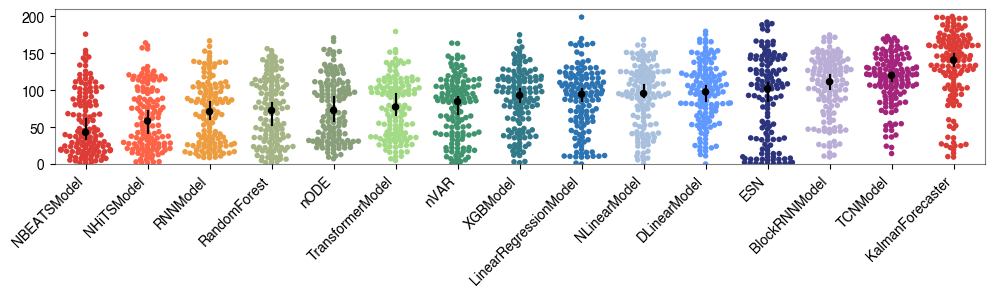

In [10]:

plt.figure(figsize=(12, 4))
# sns.violinplot(
#     data=all_scores2, 
#     zorder=0, 
#     fliersize=0, 
#     linewidth=0,
#     order=models_ranked, 
#     palette=pastel_rainbow[::-1]
# )
sns.swarmplot(
    data=all_scores,
    zorder=1,
    order=models_ranked,
    palette=pastel_rainbow,
    size=4,
    alpha=opacity_default,
)

sns.pointplot(
    data=all_scores,
    zorder=3,
    order=models_ranked,
    color=fg_color,
    markers=".",
    # linestyles="",
    estimator=np.median,
    errorbar=('ci', 95),
    scale=1,
    errwidth=1.5,
    capsize=0.0,
    join=False,
)

# sns.boxplot(
#     data=all_scores,
#     zorder=2,
#     linewidth=0,
#     order=models_ranked,
#     color="w",
#     fliersize=0,
#     # boxprops=dict(alpha=0.5),
#     # medianprops=dict(alpha=0.5),
#     # whiskerprops=dict(alpha=0.5),
#     # capprops=dict(alpha=0.5),
# )
# plt.plot(np.arange(len(models_ranked)), mean_scores, ".w", zorder=10, markersize=10)

# tilt labels
plt.xticks(rotation=45, ha="right")
plt.ylim([0, None])

dg.fixed_aspect_ratio(1/6)

## dim the axes
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.5)

# ## dim the ticks
# plt.gca().xaxis.label.set_alpha(0.5)
# plt.gca().yaxis.label.set_alpha(0.5)
# plt.gca().tick_params(axis="x", alpha=0.5)
# plt.gca().tick_params(axis="y", alpha=0.5)
# # plt.gca().tick_params(axis="y", alpha=0.5)



# dg.better_savefig(FIGPATH + "model_ranking_fixed_time.png")

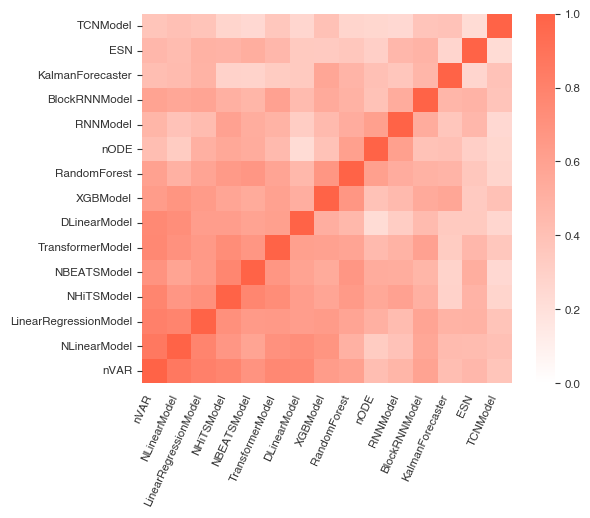

In [62]:
# plt.imshow(all_scores.corr(), vmin=0, vmax=1)
import seaborn as sns

## Sort the models by their correlation with the best model
corr_array = np.array(all_scores.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)
sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
all_scores = all_scores.iloc[:, sort_inds]

# plt.figure(figsize=(6, 6))
cmap = dg.make_linear_cmap([(1, 1, 1), dg.red])
ax = sns.heatmap(all_scores.corr(method='spearman'), cmap=cmap, vmin=0, vmax=1, square=True)
ax.invert_yaxis()
## tilt the x labels and center on tick
for item in ax.get_xticklabels():
    item.set_rotation(65)
    item.set_horizontalalignment("right")

# set font to helvetica
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')



# Best model on average
all_scores.mean(axis=0).sort_values()

dg.better_savefig(FIGPATH + "model_correlation.png", dryrun=NOSAVEFIG)


## Timing Results

In [58]:
## Timing results

## Load the timing results
fpath = "./results/results_test_multivariate__pts_per_period_100__periods_12.json_timing.json"
with open(fpath, "r") as file:
    all_timings = json.load(file)
print(len(all_timings.keys()))

## Load additional timing results
fpath = "./results/results_test_multivariate__pts_per_period_100__periods_12.json_timing_esn.json"
with open(fpath, "r") as file:
    all_timings_esn = json.load(file)


## Load additional timing results
fpath = "./results/results_test_multivariate__pts_per_period_100__periods_12.json_timing_nvar.json"
with open(fpath, "r") as file:
    all_timings_nvar = json.load(file)

## Drop unneeded keys
for item in all_timings.keys():
    # delete the "values" key if it exists
    if "values" in all_timings[item].keys():
        all_timings[item].pop("values")

## Merge the timing results
for key in all_timings_esn:
    all_timings[key].update(all_timings_esn[key])
for key in all_timings_nvar:
    all_timings[key].update(all_timings_nvar[key])

## drop any incomplete entry
keys = list(all_timings.keys())
for key in keys:
    if len(all_timings[key]) != len(all_timings["Aizawa"]):
        print(key)
        all_timings.pop(key)

## Rename NODE to nODE
for key in all_timings.keys():
    all_timings[key]["nODE"] = all_timings[key].pop("NODE")

## invert inner and outer keys
timings = dict()
for model_name in all_timings["Aizawa"].keys():
    timings[model_name] = dict()
    for equation_name in all_timings:
        timings[model_name][equation_name] = all_timings[equation_name][model_name]

print(len(timings["RNNModel"]))
timings = rename_models(timings)

133
133


In [59]:
import degas as dg

from scipy.stats import spearmanr
all_mean_timings = dict()
all_all_pairs = list()
all_centers = list()
plt.figure(figsize=(4, 4))
for i, model_name in enumerate(model_names):
    if model_name not in timings:
        print(f"Skipping {model_name}")
        continue

    all_pairs = list()
    for equation_name in timings[model_name]:
        try:
            time_val = float(timings[model_name][equation_name]["Train time"])
            # time_val = float(timings[model_name][equation_name]["Inference time"])
            error_val = float(all_scores_dict[model_name][equation_name])
            all_pairs.append((time_val, error_val))
        except KeyError:
            print(f"Skipping {model_name} {equation_name}")
            continue
    all_pairs = np.array(all_pairs)
    mean_time = np.median(all_pairs[:, 0])
    all_mean_timings[model_name] = mean_time
    all_pairs[:, 0] = np.log10(all_pairs[:, 0])
    # all_pairs = all_pairs[::, ::-1]
    # plt.figure()
    # plt.plot(
    # all_pairs[:, 0], all_pairs[:, 1], '.', 
    # markersize=2, alpha=0.1, color=pastel_rainbow[i])
    # plt.plot(
    #     all_pairs[:, 0], 
    #     all_pairs[:, 1], 
    #     '.', 
    #     alpha=0.1,
    #     markersize=2, 
    #     color=color_dict[model_name], 
    #     zorder=-2
    # )
    # dg.plot_linear_confidence(
    #     all_pairs[:, 0], 
    #     all_pairs[:, 1],
    #     color=color_dict[model_name],
    #     ci_kwargs = {"color": color_dict[model_name]},
    #     show_pi=False,
    # )

    plt.plot(
        np.median(all_pairs[:, 0]), 
        np.median(all_pairs[:, 1]),
        '.', 
        markersize=15, 
        color=color_dict[model_name],
    )
    # dg.draw_ellipse(all_pairs, fill=True, edgecolor=None, alpha=0.5, facecolor=pastel_rainbow[i])
    dg.plot_cross(
        all_pairs, 
        color=color_dict[model_name],
        center="median", 
        slope="spearman", 
        scale=0.1,
        flip=False,
        aspect=1/40,
    )
    ang = np.arctan(spearmanr(all_pairs[:, 0], all_pairs[:, 1])[0])

    title_str = f"{model_name} (r={spearmanr(all_pairs[:, 1], all_pairs[:, 0])[0]:.2f})"
    print(title_str)
    # plt.title(title_str)

    all_all_pairs.append(all_pairs)
    all_centers.append(np.median(all_pairs, axis=0))

all_all_pairs = np.concatenate(all_all_pairs)
all_centers = np.array(all_centers)

dg.plot_linear_confidence(
    all_all_pairs[:, 0], 
    all_all_pairs[:, 1],
    color=(1.0, 1.0, 1.0),
    linewidth=3,
    ci_kwargs = {"color": (0.7, 0.7, 0.7), "zorder":-110},
    show_pi=False,
    ci_range=0.999999,
    zorder=-100
)

from scipy.stats import spearmanr
print(f"Spearman coefficient: {spearmanr(all_all_pairs[:, 0], all_all_pairs[:, 1])[0]}")

# plt.plot(all_all_pairs[:, 0], 
#          all_all_pairs[:, 1], 
#          '.', 
#          markersize=0.5, alpha=0.14, color=fg_color, zorder=-1
# )
# ax = sns.kdeplot(
#     x=all_all_pairs[:, 0], 
#     y=all_all_pairs[:, 1], 
#     fill=True,
#     thresh=0.1,
#     color=fg_color,
#     shade=False, 
#     bw_adjust=1.2, 
#     levels=18,
#     alpha=0.1,
#     linewidths=0.5,
#     zorder=-1
# )

min_x, min_y = np.inf, np.inf
max_x, max_y = 0, 0
for item in plt.gca().get_lines():
    vals = item.get_xdata()
    min_x = min(min_x, np.min(vals))
    max_x = max(max_x, np.max(vals))
    vals = item.get_ydata()
    min_y = min(min_y, np.min(vals))
    max_y = max(max_y, np.max(vals))
plt.xlim([min_x, max_x])
plt.ylim([min_y, max_y*1.05])
# print(min_x, max_x, min_y, max_y)
# plt.xlim([25, 130])

## Sort model names by mean time
all_mean_timings = pd.Series(all_mean_timings)
all_mean_timings = all_mean_timings.sort_values()
all_mean_timings = list(all_mean_timings.index)[::-1]
print(all_mean_timings)

# plt.xlim([0, None])
# rename y axis labels to logarithmic
# set in Helvetica
plt.gca().set_xticklabels(
    [f"$10^{{{int(y)}}}$" for y in plt.gca().get_xticks()], 
    fontdict={
    "family": 'sans-serif', 
    "fontname": "Helvetica",
    }
)

## set aspect ratio of plot to perfect square
dg.fixed_aspect_ratio(1)

# dg.better_savefig(FIGPATH + "timing_vs_error_inference.png")
dg.better_savefig(FIGPATH + "timing_vs_error_training.png")

plt.figure(figsize=(4, 4))
for model_name in model_names:
    plt.plot([], color=color_dict[model_name])
# plt.legend()
# legend with thick lines
# get line2d

from matplotlib.lines import Line2D
plt.legend(
    handles=[
        Line2D([0], [0], color=color_dict[model_name], lw=4, label=model_name)
        for i, model_name in enumerate(model_names)
    ],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize=12,
    title="Model",
    title_fontsize=14,
)

dg.better_savefig(FIGPATH + "timing_vs_error_legend.png", dryrun=NOSAVEFIG)

NameError: name 'model_names' is not defined

<Figure size 400x400 with 0 Axes>

In [ ]:
equation_name = "MackeyGlass"


from dysts.datasets import load_file
cwd = os.getcwd()
input_path = os.path.dirname(cwd) + "/dysts/data/test_multivariate__pts_per_period_100__periods_12.json.gz"
equation_data = load_file(input_path)

input_path = os.getcwd() + "/results/results_test_multivariate__pts_per_period_100__periods_12.json.gz"
all_results = load_file(input_path)

prev_vals = np.array(equation_data.dataset[equation_name]["values"])
split_point = int(5/6 * len(prev_vals))
prev_vals = prev_vals[:split_point]

prev_vals = prev_vals[-400:]

true_vals = np.array(all_results[equation_name]["values"])

plt_models = models_ranked[:4]

plt.figure()
plt.plot(
    np.vstack([prev_vals, true_vals])[:, 0], 
    linewidth=4,
    zorder=-30,
    color=list(fg_color) + [0.2]
)
for i, model_name in enumerate(plt_models):
    plt.plot(len(prev_vals) + np.arange(len(true_vals) + 1),
        np.array(all_results[equation_name][model_name]["prediction"])[:, 0],
        color=dg.pastel_rainbow[i],
        zorder=-i
    )
dg.vanish_axes()
dg.fixed_aspect_ratio(1/6)

dg.better_savefig(FIGPATH + f"forecast_examples_univariate_{equation_name}.png", dpi=800)

plt.figure()
plt.plot(
        np.vstack([prev_vals, true_vals])[:, 0], 
        np.vstack([prev_vals, true_vals])[:, 1], 
        linewidth=4,
        zorder=-30,
        color=list(fg_color) + [0.2]
)
for i, model_name in enumerate(plt_models):
    plt.plot(
        np.array(all_results[equation_name][model_name]["prediction"])[:, 0],
        np.array(all_results[equation_name][model_name]["prediction"])[:, 2],
        color=dg.pastel_rainbow[i],
        zorder=-i
    )
# dg.vanish_axes()
# dg.fixed_aspect_ratio(1/6)


dg.better_savefig(FIGPATH + f"forecast_examples_multivariate_{equation_name}.png", dpi=800)

## Long forecast task

In [1]:
## Load long forecasting dataset

import gzip

from dysts.metrics import smape, nrmse
import dysts.flows as dfl
import json

## Load data from long forecasting task
fpath = os.getcwd() + "/results/results_test_multivariate__pts_per_period_100__periods_60.json.gz"
all_results = gzip.open(fpath, mode='r').read()
all_results = json.loads(all_results)

## Load and append neural ode results
fpath = os.getcwd() + "/results/results_neural_ode_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_node = gzip.open(fpath, mode='r').read()
all_results_node = json.loads(all_results_node)
for key in all_results.keys():
    if key not in all_results_node.keys():
        continue
    all_results[key]["NODEModel"] = dict()
    all_results[key]["NODEModel"]["prediction"] = all_results_node[key]["traj_pred"]
    all_results[key]["NODEModel"]["smape"] = all_results_node[key]["smape"]

## Load and append echo state network results
fpath = os.getcwd() + "/results/results_esn_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_esn = gzip.open(fpath, mode='r').read()
all_results_esn = json.loads(all_results_esn)
for key in all_results.keys():
    if key not in all_results_esn.keys():
        continue
    all_results[key]["ESNModel"] = dict()
    all_results[key]["ESNModel"]["prediction"] = all_results_esn[key]["traj_pred"]
    all_results[key]["ESNModel"]["smape"] = all_results_esn[key]["smape"]


fpath = os.getcwd() + "/results/results_nvar_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_nvar = gzip.open(fpath, mode='r').read()
all_results_nvar = json.loads(all_results_nvar)
for key in all_results.keys():
    if key not in all_results_nvar.keys():
        continue
    all_results[key]["NVARModel"] = dict()
    all_results[key]["NVARModel"]["prediction"] = all_results_nvar[key]["traj_pred"]
    all_results[key]["NVARModel"]["smape"] = all_results_nvar[key]["smape"]


import dysts.flows as dfl
## Fetch all lyapunov exponents
all_lyaps = dict()
for equation_name in all_results.keys():
    eq = getattr(dfl, equation_name)()
    max_lyap = eq.maximum_lyapunov_estimated
    # score_val = all_results[equation_name]["smape"]
    all_lyaps[equation_name] = max_lyap

fpath = os.getcwd() + "/results/results_classical_multivariate.json.gz"
all_results_classical = gzip.open(fpath, mode='r').read()
all_results_classical = json.loads(all_results_classical)
for key in all_results.keys():
    if key not in all_results_classical.keys():
        continue
    for model_name in all_results_classical[key].keys():
        all_results[key][model_name] = dict()
        all_results[key][model_name]['prediction'] = all_results_classical[key][model_name]['traj_pred']

## Rename models
for key in all_results.keys():
    all_results[key] = rename_models(all_results[key])



In [2]:
## EXPENSIVE - do not run this cell unless the results have changed
## Compute the smape for each model

all_outputs = dict()
for key in all_results:
    true_vals = np.array(all_results[key]["values"])
    all_traces = dict()
    for key2 in all_results[key]:
        if key2 == "values":
            continue

        pred_vals = np.array(all_results[key][key2]["prediction"])

        ## Some models fail to generate forecasts
        if np.any(pred_vals == None):
            continue
        
        ## probably need to exclude the maximum lookback window, since some models
        ## just learn a difference operator
        all_errs = []
        for i in range(1, true_vals.shape[0]):
            true_vals_sub = true_vals[:i, :]
            pred_vals_sub = pred_vals[:i, :]
            err_val = smape(true_vals_sub, pred_vals_sub)
            # err_val = nrmse(true_vals_sub, pred_vals_sub) # grows without bound
            all_errs.append(err_val)
        all_traces[key2] = np.array(all_errs)
    all_outputs[key] = all_traces



/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/metrics.py:212: RuntimeWarning: overflow encountered in square
  np.mean((y_true - y_pred)**2)) / np.sqrt(np.mean(y_true**2)


In [11]:
## save all outputs using json.dump and gzip
# import json
# from dysts.datasets import convert_json_to_gzip
# fname = "./private_archive/all_outputs_long_forecasting.json"
# with open(fname, 'w') as file:
#     all_output_list = dict()
#     for key in all_outputs.keys():
#         all_output_list[key] = dict()
#         for key2 in all_outputs[key].keys():
#             output_vals = all_outputs[key][key2]
#             output_vals[np.isnan(output_vals)] = None
#             all_output_list[key][key2] = list(output_vals)
#     json.dump(all_output_list, file, indent=4, sort_keys=True)
# convert_json_to_gzip(fname)



# ## Load all outputs from cell above
import json, gzip
with gzip.open('./private_archive/all_outputs_long_forecasting.json.gz', 'rt', encoding="utf-8") as file:
    all_outputs = json.load(file)
    for key in all_outputs.keys():
        for key2 in all_outputs[key].keys():
            all_outputs[key][key2] = np.array(all_outputs[key][key2])

In [12]:


from scipy.stats import median_abs_deviation
all_smape_series = dict()
for model_name in all_outputs["Aizawa"].keys():
    all_errs = []
    for equation_name in all_outputs.keys():
        if model_name not in all_outputs[equation_name].keys():
            print(f"skipping {model_name} for {equation_name}")
            continue
        err_val = all_outputs[equation_name][model_name]
        all_errs.append(err_val)
    all_errs = np.array(all_errs)

    all_smape_series[model_name] = dict()
    all_smape_series[model_name]["median"] = np.nanmedian(all_errs, axis=0)
    all_smape_series[model_name]["p75"] = np.percentile(all_errs, 75, axis=0)
    all_smape_series[model_name]["p25"] = np.percentile(all_errs, 25, axis=0)
    all_smape_series[model_name]["mad"] = median_abs_deviation(all_errs, axis=0)
    all_smape_series[model_name]["mean"] = np.nanmean(all_errs, axis=0)
    all_smape_series[model_name]["stderr"] = np.nanstd(all_errs, axis=0) / np.sqrt(all_errs.shape[0])


    


skipping ARIMA for BelousovZhabotinsky
skipping ARIMA for BickleyJet
skipping ARIMA for ExcitableCell
skipping ARIMA for SwingingAtwood
skipping Linear for MacArthur


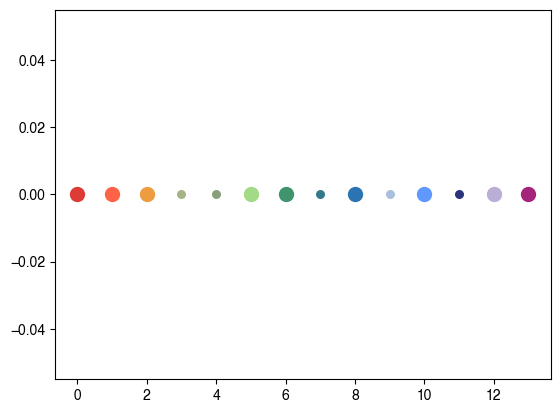

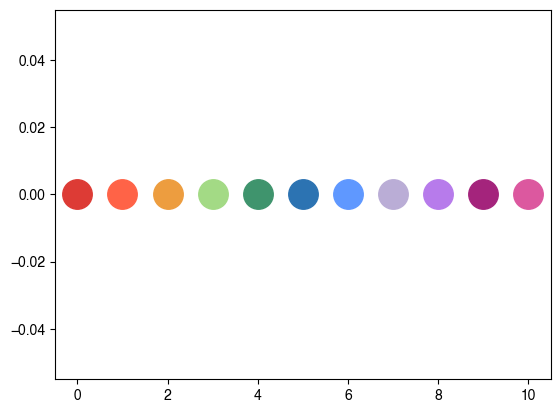

In [6]:
model_names = model_names[:len(pastel_rainbow)]
color_dict = dict(zip(model_names, pastel_rainbow))

color_palette = list()

## Show all colors
import matplotlib.pyplot as plt
for i, key in enumerate(color_dict.keys()):
    if i in [3, 4, 7, 9, 11]: 
        plt.scatter([i], [0], color=color_dict[key], label=key, zorder=10, s=30)
    else:
        plt.scatter([i], [0], color=color_dict[key], label=key, zorder=10, s=100)
        color_palette.append(color_dict[key])
color_palette.append(dg.lighter(dg.magenta, 0.3))
# color_palette.append(dg.purple)
color_palette.append(dg.lighter(dg.purple, 0.3))
    
color_palette = dg.color_sort(np.array(color_palette), method="hue")

plt.figure()
for i, clr in enumerate(color_palette):
    plt.scatter(
        [i], [0], 
        color=clr, 
        label=key, 
        zorder=10, 
        s=450
    )

# plt.cm.get_cmap('Set2', 8)
# color_palette = cmap(np.linspace(0, 1, 8))[:-1] 

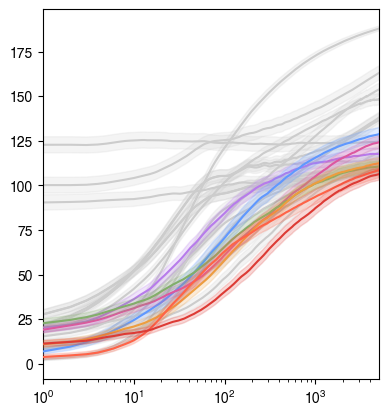

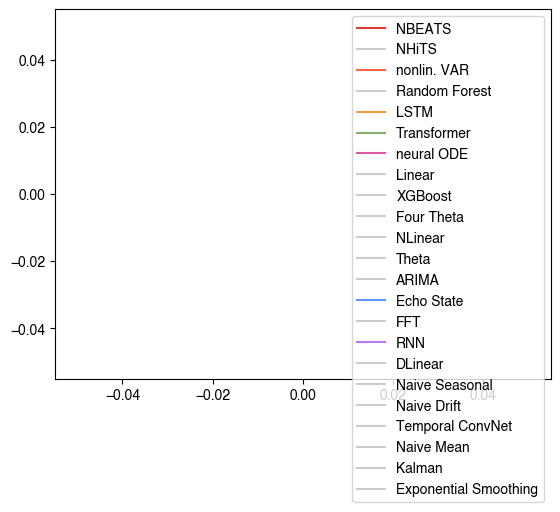

In [14]:

## rank all forecasting models in order of error
model_names = list(all_smape_series.keys())
all_smape_series_ranked = list()
for model_name in model_names:
    all_smape_series_ranked.append(all_smape_series[model_name]["mean"])
all_smape_series_ranked = np.array(all_smape_series_ranked)
# all_smape_series_ranked = all_smape_series_ranked.argsort(axis=0).argsort(axis=0)
# model_ranking = np.argsort(np.median(all_smape_series_ranked, axis=1))
model_ranking = all_smape_series_ranked[:, :1000].argsort(axis=0).argsort(axis=0).mean(axis=1).argsort()
model_names = np.array(model_names)[model_ranking]
# model_names = model_names[:len(pastel_rainbow)]
# color_dict = dict(zip(model_names, pastel_rainbow))

gray_color = np.array([0.8, 0.8, 0.8])
color_dict = {name : gray_color for name in model_names}
# color_dict.update(
#     dict(zip(model_names[:len(color_palette)], color_palette))
# )
color_dict["NBEATS"] = color_palette[0]
color_dict["nonlin. VAR"] = color_palette[1]
color_dict["LSTM"] = color_palette[2]
color_dict["Transformer"] = dg.darker(color_palette[3], 0.2)
color_dict["neural ODE"] = color_palette[-1]
color_dict["Echo State"] = color_palette[6]
color_dict["RNN"] = color_palette[-3]
# color_dict["XGBoost"] = color_palette[7]
# color_dict["Exponential Smoothing"] = color_palette[-3]


# cmap = plt.cm.get_cmap('rainbow_r', 256)
# cmap = plt.cm.get_cmap('Set2', 256)
# color_palette = cmap(np.linspace(0, 1, len(model_names))) 
# color_dict = dict(zip(model_names, color_palette))

## Plot all models mean and errors
i = 0
for model_name in model_names[::-1]:
    color = color_dict[model_name]

    ## Plot gray models behind colored models
    if np.all(color == gray_color):
        zorder_shift = -100
    else:
        zorder_shift = 0

    plt.fill_between(
        np.arange(all_smape_series[model_name]["mean"].shape[0]),
        all_smape_series[model_name]["mean"] - all_smape_series[model_name]["stderr"],
        all_smape_series[model_name]["mean"] + all_smape_series[model_name]["stderr"],
        color=color,
        alpha=0.2,
        zorder=i + zorder_shift
    )
    plt.semilogx(all_smape_series[model_name]["mean"], color=color, zorder=i+1 + zorder_shift)
    i += 2
    
## Square aspect ratio with logaritmic x-axis
plt.gca().set_aspect(1 / plt.gca().get_data_ratio(), adjustable='box')
plt.gca().set_xscale("log")
## tight xlim bounds to avoid white space
plt.xlim(1, all_smape_series[model_name]["mean"].shape[0])
# dg.better_savefig(FIGPATH + "forecast_length.png", dpi=450)



# ## Square aspect ratio with logaritmic x-axis
# plt.gca().set_aspect(1/2.0 / plt.gca().get_data_ratio(), adjustable='box')
# plt.gca().set_xscale("log")
# ## tight xlim bounds to avoid white space
# plt.xlim(1, all_smape_series[model_name]["mean"].shape[0])
# dg.better_savefig(FIGPATH + "forecast_lengths_long.png", dpi=450)

## make a separate legend for the fill_between
plt.figure()
for model_name in model_names:
    plt.plot([], color=color_dict[model_name], label=model_name)
plt.legend()
# dg.better_savefig(FIGPATH + "forecast_lengths_legend.png", dpi=450, dryrun=NOSAVEFIG)





In [32]:
## Plot in lyapunov time units
## degrees of freedom

import dysts.flows as dfl

max_lyap_times = list()
# units of Lyapunov time
timepoint_grid = np.linspace(1, 100, 1000) 
timepoint_grid = np.logspace(-2, np.log10(100), 1000)
timepoint_grid = np.logspace(-3, 3, 2000)


## Get the data to lookup timescales
cwd = os.getcwd()
input_path = os.path.dirname(cwd) 
input_path += "/dysts/data/test_multivariate__pts_per_period_100__periods_12.json.gz"
equation_data = load_file(input_path)


def interpolate_nan(y):
    """Interpolate over NaNs in a 1D array."""
    x = np.arange(y.shape[0])
    y = y.copy()
    y[np.isnan(y)] = np.interp(x[np.isnan(y)], x[~np.isnan(y)], y[~np.isnan(y)])
    return y

all_prediction_results = dict()
equation_names = sorted(list(all_outputs.keys()))
for model_name in model_names:

    all_predictions = list()
    for equation_name in equation_names:
        
        ## Get the times
        # time_vals = equation_data.dataset[equation_name]["time"]
        # dtval = np.median(np.diff(time_vals))
        tt, _ = eq.make_trajectory(
            1000, 
            resample=True, 
            return_times=True, 
            pts_per_period=100
        )
        dtval = np.median(np.diff(tt))
        
        ## Get the Lyapunov exponent
        eq = getattr(dfl, equation_name)()
        lyap = eq.maximum_lyapunov_estimated

        if model_name not in all_outputs[equation_name].keys():
            print(f"skipping {model_name} for {equation_name}")
            all_predictions.append(np.nan * timepoint_grid)
            continue
        prediction = all_outputs[equation_name][model_name]
        prediction = interpolate_nan(prediction)
        time_vals = np.arange(prediction.shape[0])
        time_vals_lyap = lyap * time_vals * dtval
        max_lyap_times.append(time_vals_lyap[-1])

        ## Account for jaggedness by only resample in valid interpolation range
        cutoff_index = np.where(time_vals_lyap <= timepoint_grid[-1])[0][-1]
        prediction_grid = np.zeros(len(timepoint_grid))
        prediction_resample = np.interp(
            timepoint_grid[:cutoff_index],
            time_vals_lyap, 
            prediction, 
        )

        prediction_grid[:cutoff_index] += prediction_resample
        prediction_grid[cutoff_index:] = np.nan
        all_predictions.append(prediction_grid)
    all_predictions = np.array(all_predictions)

    all_prediction_results[model_name] = all_predictions
num_dof = np.sum(~np.isnan(all_predictions), axis=0)

## Print 10th and 90th percentile of Lyapunov exponent-scaled times
print(np.percentile(max_lyap_times, 10))
print(np.percentile(max_lyap_times, 50))
print(np.percentile(max_lyap_times, 90))

# average_prediction = np.nanmean(all_predictions, axis=0)
# error_prediction = np.nanmean(all_predictions, axis=0)


# plt.figure()
# plt.semilogx(timepoint_grid, average_prediction, color='w')
# plt.xlim([None, np.max(timepoint_grid)])

## Confirm that truncation didn't drop statistical power
# plt.plot(num_dof)
# plt.plot(np.nanstd(all_predictions, axis=0))

/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:309: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


skipping Linear for MacArthur
skipping ARIMA for BelousovZhabotinsky
skipping ARIMA for BickleyJet
skipping ARIMA for ExcitableCell
skipping ARIMA for SwingingAtwood
4.803596999758659
48.93888078673629
422.75942857243155


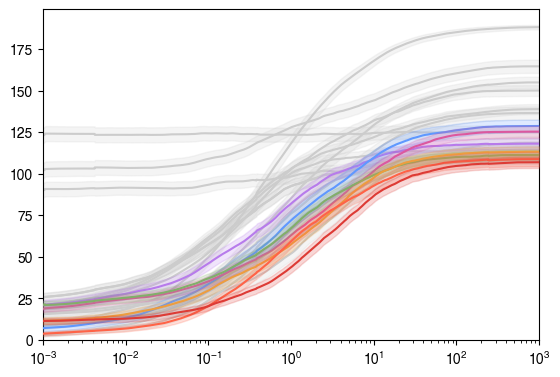

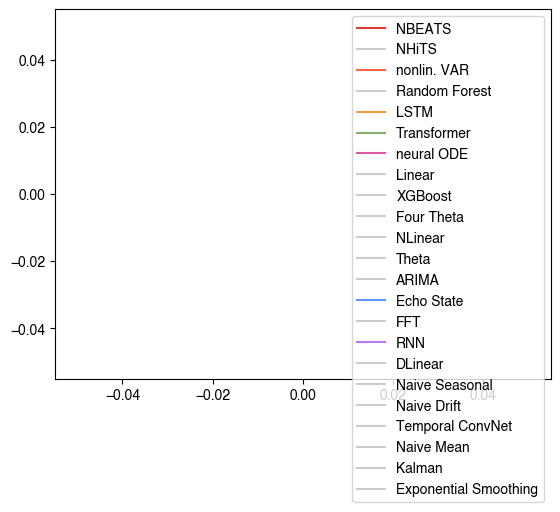

In [33]:
## Plot all models mean and errors

# model_names = list(all_prediction_results.keys())
all_results_rescaled = []
zorder_index = 0
for model_name in model_names[::-1]:
    results_ave = np.nanmean(all_prediction_results[model_name], axis=0)
    all_results_rescaled.append(results_ave)
    results_std = np.nanstd(all_prediction_results[model_name], axis=0)
    results_dof = np.sum(~np.isnan(all_prediction_results[model_name]), axis=0)
    results_stderr = results_std / np.sqrt(results_dof)

    color = color_dict[model_name]
    ## Plot gray models behind colored models
    if np.all(color == gray_color):
        zorder_shift = -100
    else:
        zorder_shift = 0

    plt.fill_between(
        timepoint_grid,
        results_ave - results_stderr,
        results_ave + results_stderr,
        color=color_dict[model_name],
        alpha=0.2,
        zorder=zorder_index + zorder_shift
    )
    plt.semilogx(
        timepoint_grid, 
        results_ave, 
        color=color_dict[model_name], 
        zorder=zorder_index + 1 + zorder_shift
    )
    zorder_index += 2
all_results_rescaled = np.array(all_results_rescaled)

plt.xlim([np.min(timepoint_grid), np.max(timepoint_grid)])
plt.ylim([0, None])
# plt.xlim([None, np.max(timepoint_grid)])
dg.fixed_aspect_ratio(1/1.5, semilogx=True)
## Verticale dashed line at x = 1.0
# plt.axvline(1.0, 
#             color='k', linestyle='--', alpha=0.3, zorder=-1000, linewidth=1,
#             dashes=(14, 4)
# )
dg.better_savefig(FIGPATH + "forecast_lengths.png", dpi=450, dryrun=NOSAVEFIG)

## make a separate legend for the fill_between
plt.figure()
for i, model_name in enumerate(model_names):
    plt.plot([], color=color_dict[model_name], label=model_name)
plt.legend()
dg.better_savefig(FIGPATH + "forecast_lengths_legend.png", dpi=450, dryrun=NOSAVEFIG)






#### Plot an example trajectory and attractor

KeyError: 'NBEATS'

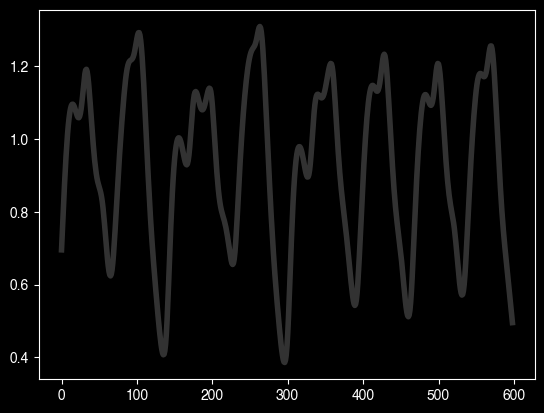

In [7]:
equation_name = "MackeyGlass"


from dysts.datasets import load_file
cwd = os.getcwd()
input_path = os.path.dirname(cwd) + "/dysts/data/test_multivariate__pts_per_period_100__periods_12.json.gz"
equation_data = load_file(input_path)

input_path = os.getcwd() + "/results/results_test_multivariate__pts_per_period_100__periods_12.json.gz"
all_results = load_file(input_path)

prev_vals = np.array(equation_data.dataset[equation_name]["values"])
split_point = int(5/6 * len(prev_vals))
prev_vals = prev_vals[:split_point]

prev_vals = prev_vals[-400:]

true_vals = np.array(all_results[equation_name]["values"])

plt_models = model_names[:4]

plt.figure()
plt.plot(
    np.vstack([prev_vals, true_vals])[:, 0], 
    linewidth=4,
    zorder=-30,
    color=list(fg_color) + [0.2]
)
for i, model_name in enumerate(plt_models):
    plt.plot(len(prev_vals) + np.arange(len(true_vals) + 1),
        np.array(all_results[equation_name][model_name]["prediction"])[:, 0],
        color=color_dict[model_name],
        zorder=-i
    )
dg.vanish_axes()
dg.fixed_aspect_ratio(1/6)

dg.better_savefig(FIGPATH + f"forecast_examples_univariate_{equation_name}.png", dpi=800)

plt.figure()
plt.plot(
        np.vstack([prev_vals, true_vals])[:, 0], 
        np.vstack([prev_vals, true_vals])[:, 1], 
        linewidth=4,
        zorder=-30,
        color=list(fg_color) + [0.2]
)
for i, model_name in enumerate(plt_models):
    plt.plot(
        np.array(all_results[equation_name][model_name]["prediction"])[:, 0],
        np.array(all_results[equation_name][model_name]["prediction"])[:, 2],
        color=color_dict[model_name],
        zorder=-i
    )
# dg.vanish_axes()
# dg.fixed_aspect_ratio(1/6)


dg.better_savefig(FIGPATH + f"forecast_examples_multivariate_{equation_name}.png", dpi=800)

#### Plot distribution of results at a single Lyapunov time

In [138]:
def nrmse(y_true, y_pred):
    return np.sqrt(
        np.mean((y_true - y_pred)**2)) / np.sqrt(np.mean(y_true**2)
    )

def smape(y_true, y_pred):
    # return 100 * np.mean(np.abs(x - y) / (np.abs(x) + np.abs(y))) * 2
    return 200 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

all_vals = list()
for _ in range(1000):
    yt, yp = 1*np.random.rand(2, 1000)
    yp = yp
    # yp *= np.random.rand()
    # yt *= np.random.rand()
    all_vals.append(
        (nrmse(yt, yp), smape(yt, yp))
    )

all_vals = np.array(all_vals)

Text(0.1, 0.9, 'slope = 84.43')

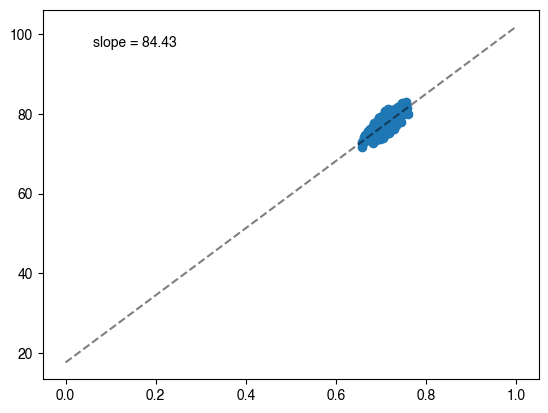

In [139]:
plt.figure()
plt.scatter(all_vals[:, 0], all_vals[:, 1])

## fit line and print slope
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(all_vals[:, 0], all_vals[:, 1])
plt.plot([0, 1], [intercept, intercept + slope], color='k', linestyle='--', alpha=0.5)
plt.text(0.1, 0.9, f"slope = {slope:.2f}", transform=plt.gca().transAxes)


In [144]:
all_prediction_results[model_name][:, highlight_index]

array([190.04967551, 181.09448734, 135.10217264,  93.97005119,
       165.61619725, 122.36223076,  94.53597329,          nan,
       178.82435583,          nan,   1.15444262,  24.07961445,
       159.08115838, 121.93888346,  48.38640743,  84.69592384,
       118.36532137, 145.41403949,          nan,  21.88227454,
       169.05428834,  26.83597601, 198.93935768, 155.98776742,
                nan, 145.39159583,  82.77820128,  55.5745787 ,
       187.43941584,          nan, 158.06470012,   2.60074153,
       176.04614255,  79.9754025 , 151.23190151, 161.46203132,
       169.83642557, 106.22032751,  25.45130762, 170.36954838,
       121.74352236, 189.00144402,  47.79659223,  38.71834653,
       145.7766072 ,  15.5795824 ,  98.36231234, 160.10273787,
       162.58804359,  77.43302537, 125.65789501,   0.82865635,
       150.62719264,  79.8155014 , 122.49945587, 158.28271704,
       146.78464766, 166.46095197, 108.5650017 , 195.61837962,
       117.20242185,   8.00013895,  80.80960306, 108.97

In [150]:
all_scores = dict()
for model_name in model_names:
    all_scores[model_name] = all_prediction_results[model_name][:, highlight_index]

In [154]:
all_scores.keys()

dict_keys(['NBEATS', 'NHiTS', 'nonlin. VAR', 'Random Forest', 'LSTM', 'Transformer', 'neural ODE', 'Linear', 'XGBoost', 'Four Theta', 'NLinear', 'Theta', 'ARIMA', 'Echo State', 'FFT', 'RNN', 'DLinear', 'Naive Seasonal', 'Naive Drift', 'Temporal ConvNet', 'Naive Mean', 'Kalman', 'Exponential Smoothing'])

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_33905/4093019788.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_scores[model_name] = np.array(all_forecast_times)


In [156]:
all_scores = dict()
for model_name in model_names:
    all_scores[model_name] = all_prediction_results[model_name][:, highlight_index]


In [160]:
all_scores = dict()
for model_name in model_names:
    all_forecast_times = list()
    for eq_index in np.arange(all_prediction_results[model_name].shape[0]):

        cross_index = np.where(
            all_prediction_results[model_name][eq_index] > 40
        )[0]

        all_forecast_times.append(timepoint_grid[cross_index])
    all_scores[model_name] = np.array(all_forecast_times)

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_33905/2618308571.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_scores[model_name] = np.array(all_forecast_times)


In [161]:
all_scores['NBEATS']

array([array([  0.13713147,   0.13840161,   0.13968351,   0.14097729,
                0.14228305,   0.1436009 ,   0.14493096,   0.14627334,
                0.14762815,   0.14899551,   0.15037553,   0.15176834,
                0.15317405,   0.15459277,   0.15602464,   0.15746977,
                0.15892829,   0.16040031,   0.16188597,   0.16338539,
                0.16489869,   0.16642602,   0.16796749,   0.16952323,
                0.17109339,   0.17267809,   0.17427747,   0.17589166,
                0.1775208 ,   0.17916503,   0.18082449,   0.18249932,
                0.18418967,   0.18589567,   0.18761747,   0.18935522,
                0.19110906,   0.19287915,   0.19466563,   0.19646866,
                0.19828839,   0.20012498,   0.20197858,   0.20384934,
                0.20573743,   0.20764301,   0.20956624,   0.21150728,
                0.2134663 ,   0.21544347,   0.21743895,   0.21945291,
                0.22148552,   0.22353696,   0.22560741,   0.22769703,
                0.22

In [159]:
all_scores['NBEATS']

array([ 85.70263445,  39.26703505,  12.25787814, 130.36355779,
        61.75372378,  68.16104383,   1.75699321,          nan,
        93.99604104,          nan,   8.53675657,  26.35732758,
        13.99220683,  30.70000238,  19.50699216,  10.39567752,
         7.10350967,  25.46593191,          nan,   4.61237985,
        91.30759297,   6.0173052 ,  54.08771922,  50.19426255,
                nan,  35.9713293 ,  50.63423732,  36.575348  ,
        59.16652697,          nan,  27.03610748,  29.44053207,
        76.14487722,  27.73118632,  15.71081036,  63.47754972,
        21.32021919,  17.05142413,   8.672705  ,  78.54149175,
        22.39069783,  53.34656556,   8.0682607 ,  25.8725781 ,
        73.75442555,  21.43982854,  19.18670051, 123.55190802,
       120.69264335,  31.24144223,  42.90269782,   8.73509033,
       100.87714485,  58.64254472,  22.18105884,  36.51726628,
        81.87806893, 139.87821086,   6.89260876,  91.00196497,
         9.95884779,   0.89958599,  33.5471333 ,  18.57

In [205]:
xx = np.array([0, 0, 0.2, 0.4, 0.6, np.nan, np.nan])

np.where(xx < 0.4)

(array([0, 1, 2]),)

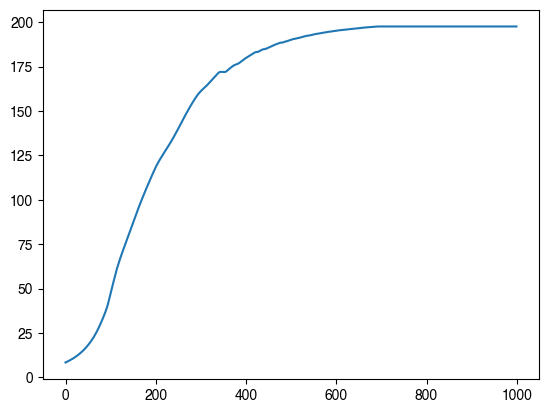

In [19]:
plt.plot(all_prediction_results[model_name][0])

In [25]:
all_forecast_times

[-1.6316316316316315,
 -1.7997997997997999,
 -0.6826826826826826,
 -0.7627627627627627,
 -1.975975975975976,
 nan,
 -0.5025025025025025,
 nan,
 nan,
 nan,
 0.850850850850851,
 0.3823823823823824,
 -1.3193193193193193,
 -0.8028028028028029,
 -0.13013013013013008,
 -0.4824824824824825,
 -0.4824824824824825,
 nan,
 -1.9239239239239239,
 0.2262262262262262,
 -1.4954954954954955,
 0.08208208208208223,
 nan,
 nan,
 -1.135135135135135,
 -0.8428428428428429,
 -0.2702702702702702,
 -0.1501501501501501,
 nan,
 -1.2872872872872874,
 -1.023023023023023,
 1.203203203203203,
 -1.8358358358358358,
 -0.35435435435435436,
 -1.5395395395395395,
 -1.5075075075075075,
 -1.4834834834834836,
 -0.35035035035035045,
 0.11811811811811787,
 -1.6996996996996998,
 -1.011011011011011,
 nan,
 -0.08608608608608616,
 0.01001001001001001,
 -0.6786786786786787,
 0.25025025025025016,
 -0.7107107107107107,
 -1.3153153153153152,
 -1.2192192192192193,
 -0.5505505505505506,
 -0.7307307307307307,
 0.7667667667667666,
 -1.947

In [42]:
all_prediction_results[model_name][eq_index][0]

0.869645670908505

16
16
18
26
18
28
14
19
16
41
16
41
19
13
108
33
7
31
26
20
129
110
8


/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


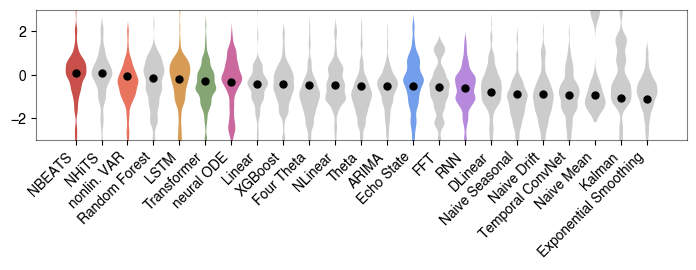

In [170]:

highlight_index = np.argmin(np.abs(timepoint_grid - 1)) # One Lyapunov time
# highlight_index = 200
all_scores = dict()
for model_name in model_names:
    all_scores[model_name] = all_prediction_results[model_name][:, highlight_index]


all_scores = dict()
for model_name in model_names:
    all_forecast_times = list()
    for eq_index in np.arange(all_prediction_results[model_name].shape[0]):

        cross_index = np.where(
            all_prediction_results[model_name][eq_index] < 40
        )[0]
        if len(cross_index) == 0:
            # if np.isnan(all_prediction_results[model_name][eq_index][0]):
            #     all_forecast_times.append(np.nan)
            # else:
            #     all_forecast_times.append(timepoint_grid[0])
            cross_index = 0
        else:
            cross_index = cross_index[-1]

        if cross_index == (len(timepoint_grid) - 1):
            all_forecast_times.append(np.nan)
        elif cross_index == 0:
            all_forecast_times.append(np.nan)
        else:
            all_forecast_times.append(np.log10(timepoint_grid[cross_index]))
    print(np.sum(np.isnan(all_forecast_times)))
    all_scores[model_name] = np.array(all_forecast_times)
    

kk = list(all_scores.keys())
all_scores = pd.DataFrame([all_scores[key] for key in kk], index=kk).transpose()
all_scores.index = equation_names


plt.figure(figsize=(12 * 0.7, 4 * 0.7))
sns.violinplot(
    data=all_scores, 
    zorder=0, 
    fliersize=0, 
    linewidth=0,
    order=list(model_names),
    # palette=pastel_rainbow[::-1]
    palette=[color_dict[model_name] for model_name in list(all_scores.columns)],
    # width of the violin
    scale="width",
    bw=0.2,
    # kde 
    # inner="box",
)

# sns.swarmplot(
#     data=all_scores,
#     zorder=1,
#     order=list(model_names),
#     palette=[color_dict[model_name] for model_name in list(all_scores.columns)],
#     size=2.5,
#     # jitter=0.3,
#     # alpha=0.2,
#     # alpha=opacity_default,
# )

# sns.swarmplot(
#     data=all_scores,
#     zorder=1,
#     order=list(model_names[sort_inds]),
#     # palette=pastel_rainbow,
#     palette=[color_dict[model_name] for model_name in list(all_scores.columns)],
#     size=3,
#     alpha=opacity_default,
# )

# sns.stripplot(
#     data=all_scores,
#     zorder=1,
#     order=list(model_names),
#     palette=[color_dict[model_name] for model_name in list(all_scores.columns)],
#     size=5,
#     jitter=0.3,
#     alpha=0.5,
#     # alpha=opacity_default,
# )


# sns.stripplot(
#     data=all_scores,
#     zorder=3,
#     order=list(model_names),
#     color=fg_color,
#     # markers=".",
#     # linestyles="",
#     estimator=np.median,
#     errorbar=('ci', 95),
#     scale=1,
#     errwidth=1.5,
#     capsize=0.0,
#     join=False,
# )

# sns.boxplot(
#     data=all_scores,
#     zorder=20,
#     # linewidth=0,
#     order=list(model_names),
#     # color='bg_color',
#     fliersize=0,
#     boxprops={'facecolor': "w", 'edgecolor': 'k'},
#     # estimator=np.median,
#     # errorbar=('ci', 95),
#     # medianprops=dict(alpha=0.5),
#     # whiskerprops=dict(alpha=0.5),
#     # capprops=dict(alpha=0.5),
# )

med_vals = [np.nanmedian(all_scores[model_name]) for model_name in model_names]
sort_inds = np.argsort(med_vals)[::-1]
plt.plot(
    np.arange(len(model_names)), 
    np.array(med_vals)[sort_inds],
    ".",
    color='k',
    zorder=10,
    markersize=10
)

# tilt labels
plt.xticks(rotation=45, ha="right")
plt.ylim([np.min(np.min(all_scores)), np.max(np.max(all_scores))])

dg.fixed_aspect_ratio(1/5)

## dim the axes
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.5)

# ## dim the ticks
# plt.gca().xaxis.label.set_alpha(0.5)
# plt.gca().yaxis.label.set_alpha(0.5)
# plt.gca().tick_params(axis="x", alpha=0.5)
# plt.gca().tick_params(axis="y", alpha=0.5)
# # plt.gca().tick_params(axis="y", alpha=0.5)

dg.better_savefig(FIGPATH + f"model_ranking_{highlight_index}.png", dryrun=NOSAVEFIG)

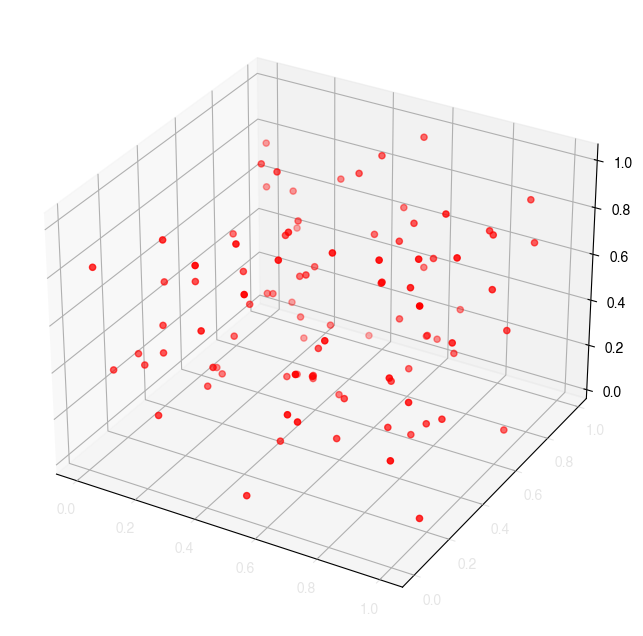

In [123]:
## Fade all ticks and frames on a plot
def dim_axes(ax=None, alpha=0.5):
    """
    Fade all ticks and frames on a plot. 

    Args:
        ax (matplotlib.axes.Axes): The axes to dim. If None, use the current axes.
        alpha (float): The alpha value to use for the dimming.

    """
    if ax is None:
        ax = plt.gca()
    ax.spines["bottom"].set_alpha(alpha)
    ax.spines["left"].set_alpha(alpha)
    ax.spines["top"].set_alpha(alpha)
    ax.spines["right"].set_alpha(alpha)
    ax.xaxis.label.set_alpha(alpha)
    ax.yaxis.label.set_alpha(alpha)
    ax.tick_params(axis="x", grid_alpha=alpha)
    ax.tick_params(axis="y", grid_alpha=alpha)
    ## dim the tick labels
    for tick in ax.get_xticklabels():
        tick.set_alpha(alpha)
    for tick in ax.get_yticklabels():
        tick.set_alpha(alpha)

    ## dim the tick lines
    for tick in ax.get_xticklines():
        tick.set_alpha(alpha)
    for tick in ax.get_yticklines():
        tick.set_alpha(alpha)


    ## for 3d plots
    if  ax.name == "3d":
        for tick in ax.get_zticklabels():
            tick.set_alpha(alpha)
        for tick in ax.get_zticklines():
            tick.set_alpha(alpha)
        ## axes
        ax.w_xaxis.line.set_alpha(alpha)
        ax.w_yaxis.line.set_alpha(alpha)
        ax.w_zaxis.line.set_alpha(alpha)
            

        
        


# sns.pointplot(
#     data=all_scores,
#     zorder=3,
#     order=list(model_names),
#     color=fg_color,
#     markers=".",
#     # linestyles="",
#     estimator=np.median,
#     errorbar=('ci', 95),
#     scale=1,
#     errwidth=1.5,
#     capsize=0.0,
#     join=False,
# )

## make a 3d scatterplot with random data
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

x = np.random.rand(100)
y = np.random.rand(100)
z = np.random.rand(100)

ax.scatter(x, y, z, c='r', marker='o')

fade_frame(alpha=0.1)

In [8]:

## Create a ranking of equations based on the SMAPE of the NBEATS model
equation_names =  np.array(list(all_results.keys()))
all_errs = []
for equation_name in all_results:
    all_errs.append(all_results[equation_name]["NBEATS"]["smape"])
equation_names = equation_names[np.argsort(np.array(all_errs))]

## Get the data to lookup timescales
# cwd = os.getcwd()
# input_path = os.path.dirname(cwd)  + "/dysts/data/test_multivariate__pts_per_period_100__periods_12.json.gz"
# equation_data = load_file(input_path)

## Plot the first 10 best-forecasted equations
model_name = "NBEATS"
window = 1000
for equation_name in equation_names[:10]:
    eq = getattr(dfl, equation_name)()
    lyap = eq.maximum_lyapunov_estimated
    print(lyap)

    tt, _ = eq.make_trajectory(1000, resample=True, return_times=True, pts_per_period=100)
    dtval = np.median(np.diff(tt))

    # tt = equation_data.dataset[equation_name]["time"]
    # dtval2 = np.median(np.diff(tt))
    # print(dtval1, dtval2)
    # dtval = dtval2

    # break
    # need to look up correct times

    true_values = np.array(all_results[equation_name]["values"])
    prediction = np.array(all_results[equation_name][model_name]["prediction"])

    tvals = np.arange(len(true_values))[-window:] * lyap * dtval

    window = 5000
    plt.figure(figsize=(6, 6))
    plt.plot(
        true_values[-window:, 0], 
        true_values[-window:, 1], 
        linewidth=2,
        zorder=-30,
        color=list(fg_color) + [0.2]
    )
    plt.plot(
        prediction[-window:, 0], 
        prediction[-window:, 1], 
        color=color_dict[model_name],
        linewidth=1,
        zorder=2
    )
    dg.fixed_aspect_ratio(1)
    plt.title(f"{equation_name} - {model_name}: Lyap = {lyap:.2f}")
    # dg.better_savefig(FIGPATH + f"attractor_examples_long_{equation_name}_{model_name}.png", dpi=800)

    # window = 1000
    # plt.figure(figsize=(12, 1.5))
    # plt.plot(
    #     tvals,
    #     true_values[-window:, 1], 
    #     linewidth=4,
    #     zorder=-30,
    #     color=list(fg_color) + [0.2]
    # )
    # plt.plot(
    #     tvals,
    #     prediction[-window:, 1], 
    #     color=color_dict[model_name],
    #     linewidth=2,
    #     zorder=2
    # )
    # plt.xlim([tvals[0], tvals[-1]])


    # plt.figure(figsize=(12, 1.5))
    # plt.plot(
    #     tvals,
    #     true_values[-window:, 0], 
    #     linewidth=4,
    #     zorder=-30,
    #     color=list(fg_color) + [0.2]
    # )
    # plt.plot(
    #     tvals,
    #     prediction[-window:, 0], 
    #     color=color_dict[model_name],
    #     linewidth=2,
    #     zorder=2
    # )
    # plt.xlim([tvals[0], tvals[-1]])

    window = 500
    tvals = np.arange(len(true_values))[:window] * lyap * dtval
    plt.figure(figsize=(5*1.3, 1.3))
    plt.plot(
        tvals,
        true_values[:window, 0], 
        linewidth=5,
        zorder=-30,
        color=list(fg_color) + [0.2]
    )
    plt.plot(
        tvals,
        prediction[:window, 0], 
        color=color_dict[model_name],
        linewidth=3,
        zorder=2
    )
    plt.xticks(np.arange(100).astype(int))
    plt.gca().set_yticks([])
    plt.xlim([tvals[0], tvals[-1]])
    plt.title(f"{equation_name} - {model_name}: Lyap = {lyap:.2f}")
    # dg.better_savefig(FIGPATH + f"forecast_examples_long_{equation_name}_{model_name}_start.png", dpi=800)


    window = 500
    tvals = np.arange(len(true_values))[-window:] * lyap * dtval
    plt.figure(figsize=(5*1.3, 1.3))
    plt.plot(
        tvals,
        true_values[-window:, 0], 
        linewidth=5,
        zorder=-30,
        color=list(fg_color) + [0.2]
    )
    plt.plot(
        tvals,
        prediction[-window:, 0], 
        color=color_dict[model_name],
        linewidth=3,
        zorder=2
    )
    plt.xticks(np.arange(100).astype(int))
    plt.gca().set_yticks([])
    plt.xlim([tvals[0], tvals[-1]])
    plt.title(f"{equation_name} - {model_name}: Lyap = {lyap:.2f}")
    dg.better_savefig(
        FIGPATH + f"forecast_examples_long_{equation_name}_{model_name}_end.png", 
        dpi=800,
        dryrun=NOSAVEFIG
    )


KeyError: 'NBEATS'

#### Compare Lyapunov spectrum and invariant properties

# Timing results revisited

In [148]:
## Timing results

## Load the timing results
fpath = "./results/results_test_multivariate__pts_per_period_100__periods_12.json_timing.json"
with open(fpath, "r") as file:
    all_timings = json.load(file)
print(len(all_timings.keys()))

## Load additional timing results
fpath = "./results/results_test_multivariate__pts_per_period_100__periods_12.json_timing_esn.json"
with open(fpath, "r") as file:
    all_timings_esn = json.load(file)


## Load additional timing results
fpath = "./results/results_test_multivariate__pts_per_period_100__periods_12.json_timing_nvar.json"
with open(fpath, "r") as file:
    all_timings_nvar = json.load(file)

## Drop unneeded keys
for item in all_timings.keys():
    # delete the "values" key if it exists
    if "values" in all_timings[item].keys():
        all_timings[item].pop("values")

## Merge the timing results
for key in all_timings_esn:
    all_timings[key].update(all_timings_esn[key])
for key in all_timings_nvar:
    all_timings[key].update(all_timings_nvar[key])

## drop any incomplete entry
keys = list(all_timings.keys())
for key in keys:
    if len(all_timings[key]) != len(all_timings["Aizawa"]):
        print(key)
        all_timings.pop(key)

## Rename NODE to nODE
for key in all_timings.keys():
    all_timings[key]["nODE"] = all_timings[key].pop("NODE")

## invert inner and outer keys
timings = dict()
for model_name in all_timings["Aizawa"].keys():
    timings[model_name] = dict()
    for equation_name in all_timings:
        timings[model_name][equation_name] = all_timings[equation_name][model_name]

fpath = os.getcwd() + "/results/results_classical_multivariate.json.gz"
all_results_classical = gzip.open(fpath, mode='r').read()
all_results_classical = json.loads(all_results_classical)
for equation_name in all_results.keys():
    # if equation_name not in all_results_classical.keys():
    #     continue
    for model_name in all_results_classical[equation_name].keys():
        if model_name not in timings.keys():
            timings[model_name] = dict()
        # all_results[key][model_name] = dict()
        # all_results[key][model_name]['prediction'] = all_results_classical[key][model_name]['traj_pred']
        timings[model_name][equation_name] = dict()
        timings[model_name][equation_name]["Train time"] = all_results_classical[equation_name][model_name]['Train time']
        timings[model_name][equation_name]['Inference time'] = all_results_classical[equation_name][model_name]['Inference time']


print(len(timings["RNNModel"]))
timings = rename_models(timings)

133
133


NBEATS (r=nan)
NHiTS (r=nan)
nonlin. VAR (r=nan)
Random Forest (r=nan)
LSTM (r=nan)
Transformer (r=nan)
neural ODE (r=nan)
Linear (r=nan)
XGBoost (r=nan)
Four Theta (r=nan)
NLinear (r=nan)
Theta (r=nan)
ARIMA (r=nan)
Echo State (r=nan)
FFT (r=nan)
RNN (r=nan)
DLinear (r=nan)
Naive Seasonal (r=nan)
Naive Drift (r=nan)
Temporal ConvNet (r=nan)
Naive Mean (r=nan)
Kalman (r=nan)
Exponential Smoothing (r=nan)
Spearman coefficient: -0.27813302512808674
['Transformer', 'NBEATS', 'LSTM', 'NHiTS', 'neural ODE', 'DLinear', 'NLinear', 'Temporal ConvNet', 'RNN', 'ARIMA', 'XGBoost', 'Random Forest', 'Exponential Smoothing', 'Echo State', 'nonlin. VAR', 'Kalman', 'Four Theta', 'Theta', 'Linear', 'FFT', 'Naive Mean', 'Naive Seasonal', 'Naive Drift']


/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_31629/724850535.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(


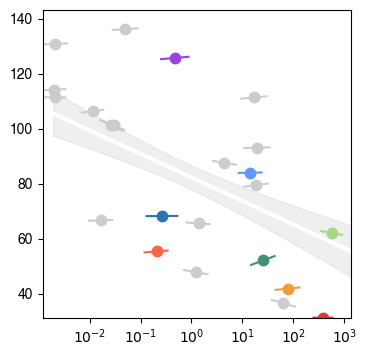

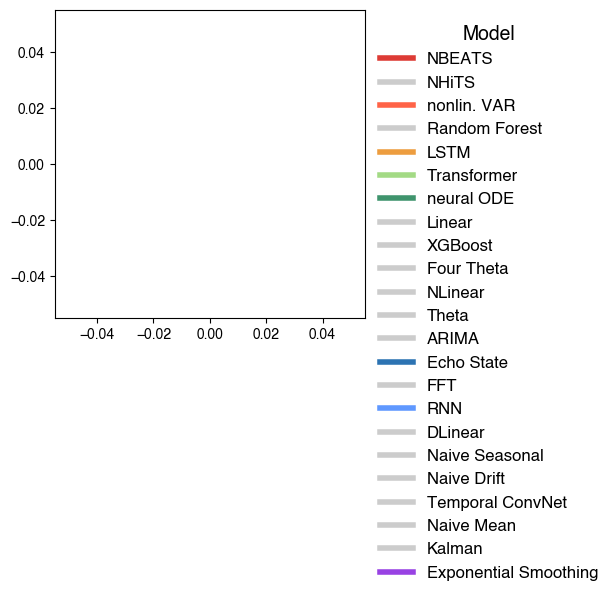

In [176]:
import degas as dg

from scipy.stats import spearmanr
all_mean_timings = dict()
all_all_pairs = list()
all_centers = list()
plt.figure(figsize=(4, 4))
for i, model_name in enumerate(model_names):
    if model_name not in timings:
        print(f"Skipping {model_name}")
        continue

    all_pairs = list()
    for equation_name in timings[model_name]:
        try:
            try:
                time_val = float(timings[model_name][equation_name]["Train time"])
            except:
                time_val = np.nan
            # time_val = float(timings[model_name][equation_name]["Train time"])
            # time_val = float(timings[model_name][equation_name]["Inference time"])
            error_val = float(all_scores.loc[equation_name][model_name])
            all_pairs.append((time_val, error_val))
        except KeyError:
            print(f"Skipping {model_name} {equation_name}")
            continue
    all_pairs = np.array(all_pairs)
    mean_time = np.nanmedian(all_pairs[:, 0])
    all_mean_timings[model_name] = mean_time
    all_pairs[:, 0] = np.log10(all_pairs[:, 0])
    # all_pairs = all_pairs[::, ::-1]
    # plt.figure()
    # plt.plot(
    # all_pairs[:, 0], all_pairs[:, 1], '.', 
    # markersize=2, alpha=0.1, color=pastel_rainbow[i])
    # plt.plot(
    #     all_pairs[:, 0], 
    #     all_pairs[:, 1], 
    #     '.', 
    #     alpha=0.1,
    #     markersize=2, 
    #     color=color_dict[model_name], 
    #     zorder=-2
    # )
    # dg.plot_linear_confidence(
    #     all_pairs[:, 0], 
    #     all_pairs[:, 1],
    #     color=color_dict[model_name],
    #     ci_kwargs = {"color": color_dict[model_name]},
    #     show_pi=False,
    # )

    plt.plot(
        np.nanmedian(all_pairs[:, 0]), 
        np.nanmedian(all_pairs[:, 1]),
        '.', 
        markersize=15, 
        color=color_dict[model_name],
    )
    # dg.draw_ellipse(all_pairs, fill=True, edgecolor=None, alpha=0.5, facecolor=pastel_rainbow[i])
    dg.plot_cross(
        all_pairs[~np.isnan(all_pairs[:, 1])],
        color=color_dict[model_name],
        center="median", 
        slope="spearman", 
        scale=0.1,
        flip=False,
        aspect=1/40,
    )
    ang = np.arctan(spearmanr(all_pairs[:, 0], all_pairs[:, 1])[0])

    title_str = f"{model_name} (r={spearmanr(all_pairs[:, 1], all_pairs[:, 0])[0]:.2f})"
    print(title_str)
    # plt.title(title_str)

    all_all_pairs.append(all_pairs)
    all_centers.append(np.nanmedian(all_pairs, axis=0))

all_all_pairs = np.concatenate(all_all_pairs)
all_centers = np.array(all_centers)

nan_pick = ~np.isnan(np.sum(all_all_pairs, axis=1))
dg.plot_linear_confidence(
    all_all_pairs[nan_pick, 0], 
    all_all_pairs[nan_pick, 1],
    color=(1.0, 1.0, 1.0),
    linewidth=3,
    ci_kwargs = {"color": (0.7, 0.7, 0.7), "zorder":-110},
    show_pi=False,
    ci_range=0.999999,
    zorder=-100
)

from scipy.stats import spearmanr
corr = spearmanr(all_all_pairs[:, 0], all_all_pairs[:, 1], nan_policy="omit")[0]
print(f"Spearman coefficient: {corr}")


# plt.plot(all_all_pairs[:, 0], 
#          all_all_pairs[:, 1], 
#          '.', 
#          markersize=0.5, alpha=0.14, color=fg_color, zorder=-1
# )
# ax = sns.kdeplot(
#     x=all_all_pairs[:, 0], 
#     y=all_all_pairs[:, 1], 
#     fill=True,
#     thresh=0.1,
#     color=fg_color,
#     shade=False, 
#     bw_adjust=1.2, 
#     levels=18,
#     alpha=0.1,
#     linewidths=0.5,
#     zorder=-1
# )

min_x, min_y = np.inf, np.inf
max_x, max_y = 0, 0
for item in plt.gca().get_lines():
    vals = item.get_xdata()
    min_x = min(min_x, np.min(vals))
    max_x = max(max_x, np.max(vals))
    vals = item.get_ydata()
    min_y = min(min_y, np.min(vals))
    max_y = max(max_y, np.max(vals))
plt.xlim([min_x, max_x])
plt.ylim([min_y, max_y*1.05])
# print(min_x, max_x, min_y, max_y)
# plt.xlim([25, 130])

## Sort model names by mean time
all_mean_timings = pd.Series(all_mean_timings)
all_mean_timings = all_mean_timings.sort_values()
all_mean_timings = list(all_mean_timings.index)[::-1]
print(all_mean_timings)

# plt.xlim([0, None])
# rename y axis labels to logarithmic
# set in Helvetica
plt.gca().set_xticklabels(
    [f"$10^{{{int(y)}}}$" for y in plt.gca().get_xticks()], 
    fontdict={
    "family": 'sans-serif', 
    "fontname": "Helvetica",
    }
)

## set aspect ratio of plot to perfect square
dg.fixed_aspect_ratio(1)

# dg.better_savefig(FIGPATH + "timing_vs_error_inference.png")
dg.better_savefig(FIGPATH + "timing_vs_error_training.png")

plt.figure(figsize=(4, 4))
for model_name in model_names:
    plt.plot([], color=color_dict[model_name])
# plt.legend()
# legend with thick lines
# get line2d

from matplotlib.lines import Line2D
plt.legend(
    handles=[
        Line2D([0], [0], color=color_dict[model_name], lw=4, label=model_name)
        for i, model_name in enumerate(model_names)
    ],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize=12,
    title="Model",
    title_fontsize=14,
)

dg.better_savefig(FIGPATH + "timing_vs_error_legend.png", dryrun=NOSAVEFIG)

In [170]:
corr = spearmanr(all_all_pairs[:, 0], all_all_pairs[:, 1], nan_policy="omit")[0]
print(f"Spearman coefficient: {corr}")

Spearman coefficient: -0.27813302512808674


## Correlations among models over time

In [160]:
from scipy.stats import spearmanr

all_modelwise_corrs = {}
num_tpts = len(all_prediction_results['NBEATS'][0])
for model_name in model_names:
    
    all_modelwise_corrs[model_name] = {}
    all_modelwise_corrs[model_name]["correlations"] = []
    all_modelwise_corrs[model_name]["errors"] = []

    all_values = []
    for i in range(num_tpts):
        ## Errors for all systems for that model at that timepoint
        model_vals = all_prediction_results[model_name][:, i]
        ## linalg norm with nans
        norm_val = np.linalg.norm(model_vals[~np.isnan(model_vals)])
        model_vals = model_vals / norm_val
        all_values.append(model_vals)
    
    # median correlation of all model errors across all timepoints
    base_vals = np.nanmedian(np.array(all_values), axis=0) # shape (num_systems)

    for i in range(num_tpts):
        model_vals = all_prediction_results[model_name][:, i]
        corr, pval = spearmanr(base_vals, model_vals, nan_policy='omit')

        all_modelwise_corrs[model_name]["correlations"].append(corr)


        ## error bar with fisher z transform
        corr_err_up = np.tanh(np.arctanh(corr) + 0.674 / np.sqrt(len(base_vals) - 3))
        corr_err_down = np.tanh(np.arctanh(corr) - 0.674 / np.sqrt(len(base_vals) - 3))
        corr_err = np.abs(corr_err_up - corr_err_down) / 2
        all_modelwise_corrs[model_name]["errors"].append(corr_err)

        ## Compute error in with bootstrap (slow, errors are small)
        # all_corrs = []
        # for _ in range(500):
        #     idx = np.random.choice(len(model_vals), size=len(model_vals), replace=True)
        #     corr, pval = spearmanr(base_vals[idx], model_vals[idx], nan_policy='omit')
        #     all_corrs.append(corr)
        # corr = np.nanmean(all_corrs)
        # corr_err = np.nanstd(all_corrs) / np.sqrt(len(all_corrs))
        # all_modelwise_corrs[model_name]["correlations"].append(corr)
        # all_modelwise_corrs[model_name]["errors"].append(corr_err)

                                        

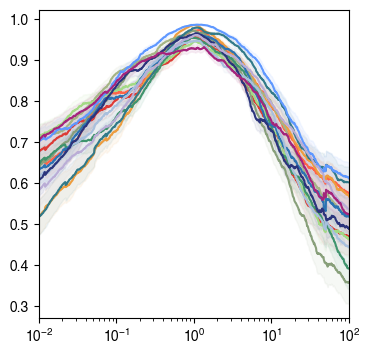

In [163]:


plt.figure(figsize=(4, 4))
for model_name in model_names:
    # plt.semilogx(
    #     timepoint_grid,
    #     all_modelwise_corrs[model_name]["correlations"],
    #     label=model_name, 
    #     color=color_dict[model_name],
    #     linewidth=1.5
    # ) 
    
    # Error bars smaller than 0.01 are not visible
    plt.semilogx([], [])
    dg.plot_err(
        all_modelwise_corrs[model_name]["correlations"],
        np.array(all_modelwise_corrs[model_name]["errors"]),
        x = timepoint_grid,
        linewidth=1.5,
        alpha=0.1,
        color=color_dict[model_name],
        label=model_name,
    )

plt.xlim([timepoint_grid[0], timepoint_grid[-1]])

dg.better_savefig(FIGPATH + "mutual_correlation.png", dpi=800, dryrun=NOSAVEFIG)


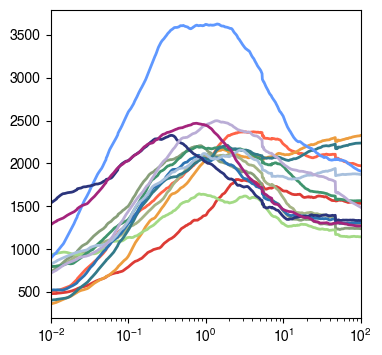

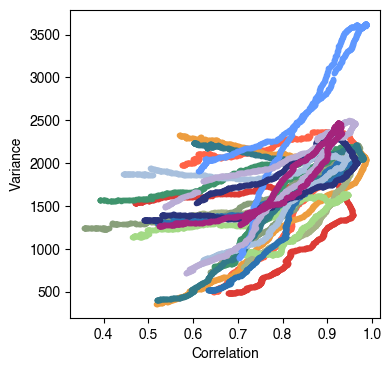

In [179]:
## Variance

all_modelwise_vars = {}
num_tpts = len(all_prediction_results['NBEATS'][0])
for model_name in model_names:

    all_modelwise_vars[model_name] = []
    for i in range(num_tpts):
        model_vals = all_prediction_results[model_name][:, i]
        all_modelwise_vars[model_name].append(np.nanvar(model_vals))

plt.figure(figsize=(4, 4))
for model_name in model_names:
    plt.semilogx(
        timepoint_grid,
        all_modelwise_vars[model_name],
        label=model_name, 
        color=color_dict[model_name],
        linewidth=2
    )
plt.xlim([timepoint_grid[0], timepoint_grid[-1]])

dg.better_savefig(FIGPATH + "variance_across_systems.png", dpi=800, dryrun=NOSAVEFIG)

## Correlate variance and correlation
plt.figure(figsize=(4, 4))
for model_name in model_names:
    plt.plot(
        all_modelwise_corrs[model_name]["correlations"],
        all_modelwise_vars[model_name],
        '.',
        label=model_name,
        color=color_dict[model_name]
    )
plt.xlabel("Correlation")
plt.ylabel("Variance")

dg.better_savefig(FIGPATH + "correlation_vs_variance.png", dpi=800, dryrun=NOSAVEFIG)



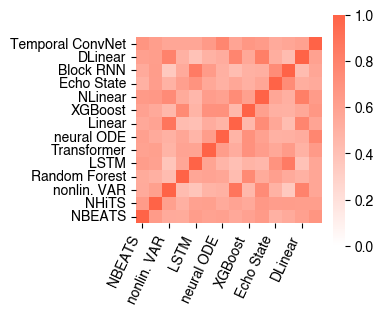

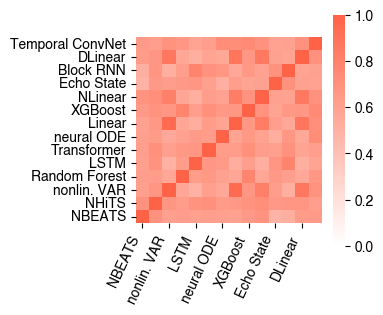

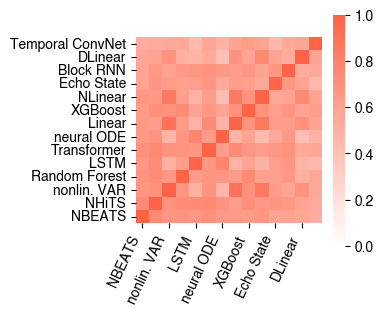

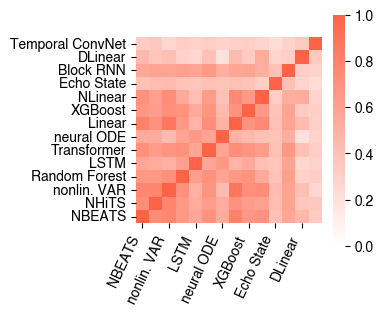

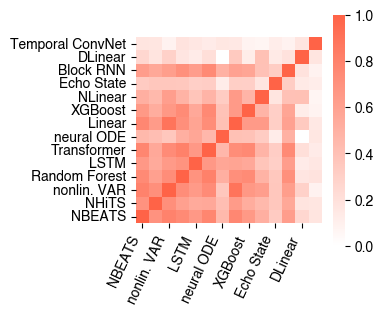

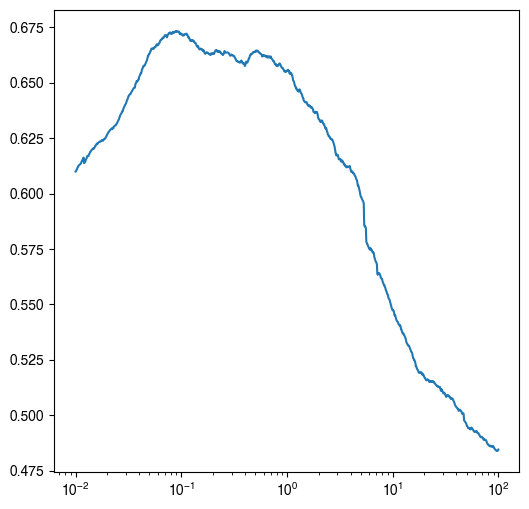

In [139]:
import seaborn as sns

cmap = dg.make_linear_cmap([(1, 1, 1), dg.red])

highlight_index = np.argmin(np.abs(timepoint_grid - 1))

for highlight_index in np.linspace(1, len(timepoint_grid) - 1, 5).astype(int):
    all_scores = dict()
    for model_name in model_names:
        all_scores[model_name] = all_prediction_results[model_name][:, highlight_index]
    kk = list(all_scores.keys())
    all_scores = pd.DataFrame([all_scores[key] for key in kk], index=kk).transpose()

    ## Sort the models by their correlation with the best model
    # corr_array = np.array(all_scores.corr(method='spearman'))
    # np.fill_diagonal(corr_array, np.nan)
    # sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
    # all_scores = all_scores.iloc[:, sort_inds]

    plt.figure(figsize=(3, 3))
    ax = sns.heatmap(all_scores.corr(method='spearman'), cmap=cmap, vmin=0, vmax=1, square=True)
    ax.invert_yaxis()
    ## tilt the x labels and center on tick
    for item in ax.get_xticklabels():
        item.set_rotation(65)
        item.set_horizontalalignment("right")

average_mutual_correlation = list()
for highlight_index in range(len(timepoint_grid)):
    all_scores = dict()
    for model_name in model_names:
        all_scores[model_name] = all_prediction_results[model_name][:, highlight_index]
    kk = list(all_scores.keys())
    all_scores = pd.DataFrame([all_scores[key] for key in kk], index=kk).transpose()
    average_mutual_correlation.append(
        np.mean(all_scores.corr(method='spearman').to_numpy())
    )
plt.figure(figsize=(6, 6))
plt.semilogx(timepoint_grid, average_mutual_correlation)

## Accuracy of Data-limited models

In [1]:
model_names = ['NBEATS' 'NHiTS' 'nonlin. VAR' 'Random Forest' 'LSTM' 'Transformer'
 'neural ODE' 'Linear' 'XGBoost' 'NLinear' 'Echo State' 'Block RNN'
 'DLinear' 'Temporal ConvNet']

In [7]:
fpath = os.getcwd() + "/results/data_sweep_test_multivariate__pts_per_period_100__periods_12.json.json"
with open(fpath, mode='r') as f:
    results_data = f.read()
    results_data_limited = json.loads(results_data)

# import re
# master_records = dict()
# for fpath_n in ["", "2", "3", "4"]:
#     fpath = os.getcwd() + "/results/"
#     fpath += "data_sweep_test_multivariate__pts_per_period_100__periods_12.json"+ fpath_n + ".json"
#     with open(fpath, mode='r') as f:
#         results_data = f.read()
#     results_data_limited = json.loads(results_data)

#     for key in list(results_data_limited.keys()):
#         if len(results_data_limited[key]) == 0:
#             del results_data_limited[key]

#     master_records.update(results_data_limited)
# results_data_limited = master_records

# output_path = '/Users/william/program_repos/dysts/benchmarks/results/'
# output_path += 'data_sweep_test_multivariate__pts_per_period_100__periods_12.json.json'
# with open(output_path, 'w') as f:
#     json.dump(results_data_limited, f, indent=4)  

fpath = os.getcwd() + "/results/" 
fpath += "data_sweep_test_multivariate__pts_per_period_100__periods_12.json_node_esn_nvar.json"
with open(fpath, mode='r') as f:
    results_data_esn = f.read()
results_data_esn = json.loads(results_data_esn)
for key in results_data_limited:
    if key in results_data_esn:
        results_data_limited[key].update(results_data_esn[key])


results_data_limited_agg = {}
for model_name in results_data_limited["Aizawa"].keys():
    results_data_limited_agg[model_name] = []
    for equation_name in results_data_limited.keys():
        try:
            traces = results_data_limited[equation_name][model_name]
            if len(traces) == 0:
                continue
            results_data_limited_agg[model_name].append(traces)
        except:
            pass
    print(f"Number of equations: {len(results_data_limited_agg[model_name])}")



results_data_limited_agg = rename_models(results_data_limited_agg)



Number of equations: 131
Number of equations: 131
Number of equations: 131
Number of equations: 131
Number of equations: 131
Number of equations: 131
Number of equations: 131
Number of equations: 131
Number of equations: 131
Number of equations: 131
Number of equations: 131
Number of equations: 129
Number of equations: 131
Number of equations: 131
Number of equations: 131


Temporal ConvNet 50
131
DLinear 75
131
Block RNN 75
131
Echo State 25
131
NLinear 75
131
XGBoost 75
131
Linear 75
131
neural ODE 25
131
Transformer 25
129
LSTM 75
131
Random Forest 75
131
nonlin. VAR 25
131
NHiTS 75
131
NBEATS 50
131


/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_88093/3061516474.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([item[-25:] for item in values])


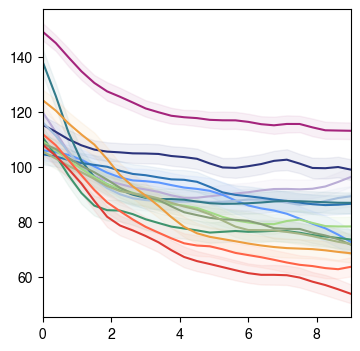

In [19]:
import degas as dg


from scipy.ndimage import gaussian_filter1d
def impute_nan(x, sigma=1.0):
    """Impute nan values in a 1d array using gaussian weighting"""
    xp = np.isnan(x)
    ## make nan filter
    x[xp] = np.interp(np.flatnonzero(xp), np.flatnonzero(~xp), x[~xp])
    ## filter the data to interpolate nans
    xp = np.isnan(x)
    xf = gaussian_filter1d(x, sigma=sigma, mode='nearest')
    return xf

plt.figure(figsize=(4, 4))
model_name_plotted = list()
for model_name in model_names[::-1]:
    if model_name not in results_data_limited_agg.keys():
        print("Missing", model_name)
        continue
    values = results_data_limited_agg[model_name]
    print(model_name, len(values[0]), flush=True)
    print(len(values), flush=True)

    ## fix duplicate appending
    values = np.array([item[-25:] for item in values])
    values[values == None] = np.nan
    values = np.array([item for item in values if len(item) == len(values[0])]).astype(float)

    # plt.plot(
    #     np.linspace(0, 9, len(values[0])),
    #     # nanmean_trimmed(values, percentile=0.2, axis=0)[::-1],
    #     impute_nan(np.nanmean(values, axis=0)[::-1]),
    #     color=color_dict[model_name],
    #     label=model_name,
    # )
    dg.plot_err(
        impute_nan(np.nanmean(values, axis=0)[::-1]),
        (np.nanstd(values, axis=0) / np.sqrt(np.sum(~np.isnan(values), axis=0)))[::-1],
        x = np.linspace(0, 9, len(values[0])),
        linewidth=1.5,
        alpha=0.1,
        color=color_dict[model_name],
        label=model_name
    )

    model_name_plotted.append(model_name)
plt.xlim([0, 9])

dg.fixed_aspect_ratio(1)
dg.better_savefig(FIGPATH + "data_decay.png", dpi=800, dryrun=NOSAVEFIG)
# dg.better_savefig(FIGPATH + "data_decay_errs.png", dpi=800, dryrun=False)


# plt.legend(model_name_plotted, loc='upper left', bbox_to_anchor=(1, 1))

In [76]:
## get average number of lyapunov times

# pts_per_period = 100
all_counts = []
for key in all_lyaps:
    ## 1000 timepoints at 100 points per period
    eq = getattr(dfl, key)()
    tpts, _ = eq.make_trajectory(1000, resample=True, return_times=True)
    all_counts.append(all_lyaps[key] * np.ptp(tpts))
print(np.median(all_counts), np.mean(all_counts))

/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:309: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


8.995333825242309 16.369934310720584


## Correlate properties with performance across time

Text(0.5, 1.0, 'Spearman correlation between forecast horizon and metrics')

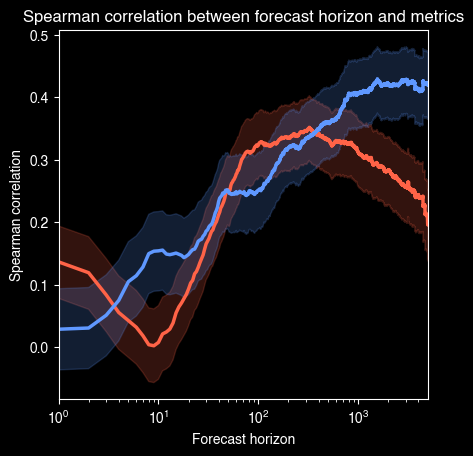

In [127]:
## try median aggregation as well

    

## aggregation across models
all_outputs_aggregated = dict()
for equation_name in all_outputs.keys():
    all_traces = list()
    for model_name in all_outputs[equation_name]:
        all_traces.append(all_outputs[equation_name][model_name])
    all_traces = np.array(all_traces)
    # all_traces = np.min(all_traces, axis=0)
    all_traces = np.mean(all_traces, axis=0)
    # all_traces = np.median(all_traces, axis=0)
    all_outputs_aggregated[equation_name] = all_traces


## Look up properties for each system and then correlate with the score
# from scipy.stats import spearmanr
# all_spearman = list()
# for i in range(all_outputs_aggregated["Aizawa"].shape[-1]):
#     all_spearman_sub, all_lyap_sub = list(), list()
#     for equation_name in all_outputs_aggregated.keys():
#         if equation_name not in all_lyaps.keys():
#             continue
#         lyap_val = all_lyaps[equation_name]
#         score_val = all_outputs_aggregated[equation_name][i]
#         all_spearman_sub.append(score_val)
#         all_lyap_sub.append(lyap_val)
#     corr_val = np.abs(spearmanr(all_lyap_sub, all_spearman_sub)[0])
#     all_spearman.append(corr_val)


## Look up properties for each system and then correlate with the score
import pandas as pd
from scipy.stats import spearmanr
orbit_features = pd.read_csv("./resources/private_topo_features3.csv", index_col=0)
orbit_features = orbit_features.transpose().to_dict()
## add lyapunov exponents
for equation_name in orbit_features:
    if equation_name in all_lyaps:
        orbit_features[equation_name]["lyapunov exponent"] = all_lyaps[equation_name]


plt.figure()
correlation_dict = dict()
# for metric_name in orbit_features["Aizawa"].keys():
# "entropy"
for metric_name in ["lyapunov exponent", "steady state participation"]:

    all_spearman = list()
    all_spearman_std = list()
    for i in range(all_outputs_aggregated["Aizawa"].shape[-1]):
        all_spearman_sub, all_metric_sub = list(), list()
        for equation_name in all_outputs_aggregated.keys():
            if equation_name not in orbit_features.keys():
                continue
            metric_val = orbit_features[equation_name][metric_name]
            if np.isnan(metric_val):
                continue
            if metric_val == None:
                continue
            score_val = all_outputs_aggregated[equation_name][i]
            all_spearman_sub.append(score_val)
            all_metric_sub.append(metric_val)
        if len(all_spearman_sub) < int(0.7 * len(orbit_features)):
            print("Excessive missing values")
        corr_val = np.abs(spearmanr(all_metric_sub, all_spearman_sub, nan_policy='omit')[0])
        all_spearman.append(corr_val)

        ## Confidence interval via Fisher transformation
        corr_err_up = np.tanh(np.arctanh(corr_val) + 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        corr_err_down = np.tanh(np.arctanh(corr_val) - 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        all_spearman_std.append([corr_err_down, corr_err_up])

    all_spearman = np.array(all_spearman)
    all_spearman_std = np.array(all_spearman_std)
    correlation_dict[metric_name] = dict()
    correlation_dict[metric_name]["spearman"] = all_spearman
    correlation_dict[metric_name]["spearman interval"] = all_spearman_std

red = [1.0, 0.3882, 0.2784]
blue = [0.372549, 0.596078, 1]
colors = [red, blue]
for i, metric_name in enumerate(correlation_dict.keys()):
    all_spearman = correlation_dict[metric_name]["spearman"]
    all_sperr = correlation_dict[metric_name]["spearman interval"]
    plt.semilogx(all_spearman, color=colors[i], linewidth=2.5)
    plt.fill_between(
        np.arange(len(all_spearman)),
        all_sperr[:, 0],
        all_sperr[:, 1],
        alpha=0.2,
        color=colors[i],
        label=metric_name,
    )

# plt.legend(correlation_dict.keys())
plt.xlim([1, len(all_spearman)])
plt.gca().set_aspect(1.0 / plt.gca().get_data_ratio(), adjustable='box')
plt.gca().set_xscale("log")

# plt.legend()

plt.xlabel("Forecast horizon")
plt.ylabel("Spearman correlation")
plt.title(f"Spearman correlation between forecast horizon and metrics")
# plt.savefig(
#     f"../private_writing2/fig_resources/forecast_horizon_correlation.png", 
#     dpi=300, 
#     bbox_inches="tight"
# )
# dg.better_savefig(FIGPATH + "forecast_horizon_correlation.png", dpi=450)



/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


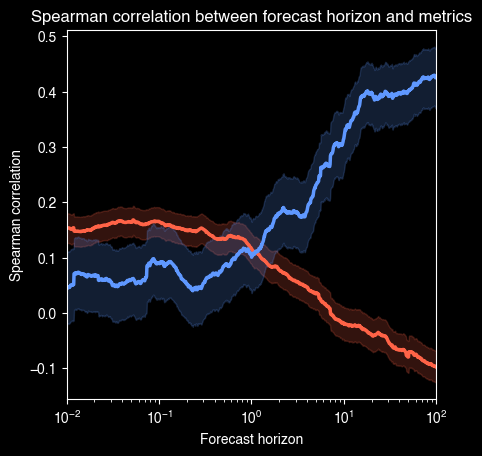

In [139]:
## aggregation across models
all_results_flat = [all_prediction_results[key] for key in all_prediction_results.keys()]
all_results_flat = np.array(all_results_flat)
all_outputs_aggregated = dict(
    zip(equation_names, np.nanmedian(all_results_flat, axis=0))
)

## Look up properties for each system and then correlate with the score
import pandas as pd
from scipy.stats import spearmanr
orbit_features = pd.read_csv("./resources/private_topo_features3.csv", index_col=0)
orbit_features = orbit_features.transpose().to_dict()
## add lyapunov exponents
for equation_name in orbit_features:
    if equation_name in all_lyaps:
        orbit_features[equation_name]["lyapunov exponent"] = all_lyaps[equation_name]

from scipy.stats import spearmanr
plt.figure()
correlation_dict = dict()
# for metric_name in orbit_features["Aizawa"].keys():
for metric_name in ["lyapunov exponent", "steady state participation"]:

    all_spearman = list()
    all_spearman_std = list()
    score_ave = list()
    for i in range(all_outputs_aggregated["Aizawa"].shape[-1]):
        all_spearman_sub, all_metric_sub = list(), list()
        for equation_name in all_outputs_aggregated.keys():
            if equation_name not in orbit_features.keys():
                continue
            metric_val = orbit_features[equation_name][metric_name]
            if metric_name == "lyapunov exponent":
                metric_val = 1 / metric_val
            if np.isnan(metric_val):
                continue
            if metric_val == None:
                continue
            score_val = all_outputs_aggregated[equation_name][i]
            all_spearman_sub.append(score_val)
            all_metric_sub.append(metric_val)
        if len(all_spearman_sub) < int(0.7 * len(orbit_features)):
            print("Excessive missing values")
        corr_val = spearmanr(all_metric_sub, all_spearman_sub, nan_policy='omit')[0]
        all_spearman.append(corr_val)

        score_ave.append(np.nanmean(all_spearman_sub))

        ## Confidence interval via Fisher transformation
        corr_err_up = np.tanh(np.arctanh(corr_val) + 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        corr_err_down = np.tanh(np.arctanh(corr_val) - 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        all_spearman_std.append([corr_err_down, corr_err_up])

    all_spearman = np.array(all_spearman)
    all_spearman_std = np.array(all_spearman_std)
    correlation_dict[metric_name] = dict()
    correlation_dict[metric_name]["spearman"] = all_spearman
    correlation_dict[metric_name]["spearman interval"] = all_spearman_std

red = [1.0, 0.3882, 0.2784]
blue = [0.372549, 0.596078, 1]
colors = dict(zip(["lyapunov exponent", "steady state participation"], [red, blue]))
plt.semilogx([])
for i, metric_name in enumerate(correlation_dict.keys()):

    all_spearman = correlation_dict[metric_name]["spearman"]
    all_sperr = correlation_dict[metric_name]["spearman interval"]

    plt.semilogx(
        timepoint_grid, 
        all_spearman, 
        color=colors[metric_name], 
        linewidth=2.5,
        label=metric_name
    )
    plt.fill_between(
        timepoint_grid,
        all_sperr[:, 0],
        all_sperr[:, 1],
        alpha=0.2,
        color=colors[metric_name],
    )

plt.xlim([np.min(timepoint_grid), np.max(timepoint_grid)])
# plt.legend()

plt.xlabel("Forecast horizon")
plt.ylabel("Spearman correlation")
plt.title(f"Spearman correlation between forecast horizon and metrics")
dg.fixed_aspect_ratio(1, semilogx=True)

dg.better_savefig(FIGPATH + "forecast_horizon_correlation_rescaled.png", dpi=450)


# .

# Appendix

## Lyapunov exponent calculation

In [ ]:
from dysts.analysis import lyapunov_exponent_naive#, get_attractor_list
from dysts.flows import *
import dysts.flows as dfl

# all_attractors = get_attractor_list()

# for equation_name in all_attractors:
#     eq = getattr(dfl, equation_name)()
all_names = []
for eq in [MackeyGlass(), Aizawa(), Lorenz()]:
    all_names.append(eq.name)
    tpts, sol1 = eq.make_trajectory(2000, resample=True, return_times=True)
    eq.ic *= (1 + 1e-12)
    sol2 = eq.make_trajectory(2000, resample=True)
    separation = np.linalg.norm(sol1 - sol2, axis=1)

    plt.semilogy(tpts, separation)
    lyap_est = np.polyfit(tpts, np.log(separation), 1)[0]
    print(f"{eq.name}: {lyap_est:.4f} ")

plt.legend(all_names)
# lyap = lyapunov_exponent_naive(eq, traj_length=200, n_samples=90)
# print(lyap)



In [ ]:
from dysts.analysis import lyapunov_exponent_naive
from dysts.flows import *

eq = MackeyGlass()
# a = 0.2, b = 0.1, c = 10, and T = 23
# eq = MackeyGlass()
eq.beta = 0.2
eq.gamma = 0.1
eq.n = 10
eq.tau = 23

# sol = eq.make_trajectory(4000, resample=True)
# plt.figure()
# plt.plot(sol[:, 0], sol[:, 1])
# eq.period /= 10
lyap = lyapunov_exponent_naive(eq, traj_length=2000, n_samples=20)
print(lyap)

In [19]:
from dysts.analysis import lyapunov_exponent_naive
from dysts.flows import *

eq = BlinkingVortex()
lyap = lyapunov_exponent_naive(eq) # 0.8917098035724058 0.2457084451352168
print(lyap)

# skipping BlinkingVortex
# skipping LiuChen
# skipping Lorenz

/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:282: UserWarning: Expect slowdown due to excessive integration required; scale factor 1194.7508832648352
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:309: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


In [ ]:
import json


with open("../dysts/data/chaotic_attractors.json", "r") as f:
    dataset = json.load(f)

# new values
with open("../dysts/data/lyapunov_exponents_naive_mean.txt", "r") as f:
    # load entries of hte form "equation_name: lyapunov_exponent" into a dict
    lyapunov_exponents = dict([line.split(": ") for line in f.read().splitlines()])
    # convert to float
    lyapunov_exponents = {k: float(v) for k, v in lyapunov_exponents.items()}

## update values
for key in dataset:
    if key in lyapunov_exponents:
        dataset[key]["maximum_lyapunov_estimated"] = lyapunov_exponents[key]
    else:
        print(f"skipping {key}")

## save
# with open("../dysts/data/chaotic_attractors.json", "w") as f:
#     json.dump(dataset, f, indent=4)


SpearmanrResult(correlation=0.9590104834279436, pvalue=7.336282706365214e-71)


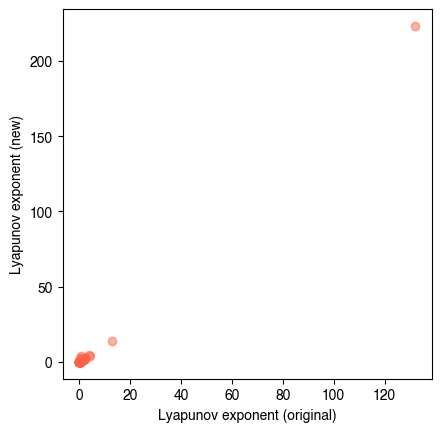

In [61]:
## Read lyapunov values from file
# with open("../dysts/data/lyapunov_exponents_qr.txt", "r") as f:
with open("../dysts/data/lyapunov_exponents_naive_mean.txt", "r") as f:
    # load entries of hte form "equation_name: lyapunov_exponent" into a dict
    lyapunov_exponents1 = dict([line.split(": ") for line in f.read().splitlines()])
    # convert to float
    lyapunov_exponents1 = {k: float(v) for k, v in lyapunov_exponents1.items()}

## Read lyapunov values from file
with open("../dysts/data/lyapunov_exponents_naive_short.txt", "r") as f:
    # load entries of hte form "equation_name: lyapunov_exponent" into a dict
    lyapunov_exponents2 = dict([line.split(": ") for line in f.read().splitlines()])
    # convert to float
    lyapunov_exponents2 = {k: float(v) for k, v in lyapunov_exponents2.items()}

all_pairs = []
for key in lyapunov_exponents1:
    if key in lyapunov_exponents2:
        all_pairs.append((lyapunov_exponents1[key], lyapunov_exponents2[key]))
all_pairs = np.array(all_pairs)

## Compare on a plot
plt.figure()
plt.scatter(all_pairs[:, 0], all_pairs[:, 1], color=dg.red, alpha=0.5)
plt.xlabel("Lyapunov exponent (original)")
plt.ylabel("Lyapunov exponent (new)")
from scipy.stats import spearmanr
print(spearmanr(all_pairs[:, 0], all_pairs[:, 1]))

dg.fixed_aspect_ratio(1)


In [ ]:
all_data = []
for model_name in model_names:
    for i in range(len(all_prediction_results['NBEATS'][0])):
        model_vals = all_prediction_results[model_name][:, i]
        all_data.append(model_vals)
all_data = np.array(all_data)

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

pca = PCA(n_components=1)

imputer = SimpleImputer()
all_data = imputer.fit_transform(all_data)
all_data /= np.linalg.norm(all_data, axis=0, keepdims=True)
all_data = pca.fit_transform(all_data)


all_modelwise_corrs = {}
for model_name in model_names:

    all_modelwise_corrs[model_name] = []
    for i in range(len(all_prediction_results['NBEATS'][0])):
        model_vals = all_prediction_results[model_name][:, i]
        model_vals = imputer.transform(model_vals[None, :])
        model_vals /= np.linalg.norm(model_vals, axis=1, keepdims=True)
        model_vals = pca.transform(model_vals)
        all_modelwise_corrs[model_name].append(float(model_vals.squeeze()))
        


In [ ]:

# best_scores = pd.DataFrame(all_scores["NBEATSModel"])
best_scores = pd.DataFrame(all_scores.min(axis=1).sort_values())
best_scores.columns = ["smape"]

# add column for lyapunov exponents
best_scores["lyapunov"] = np.nan * np.ones(best_scores.shape[0])

import dysts.flows as dfl

for equation_name in best_scores.index:
    eq = getattr(dfl, equation_name)()
    max_lyap = eq.maximum_lyapunov_estimated
    # score_val = all_results[equation_name]["smape"]
    best_scores.loc[equation_name, "lyapunov"] = max_lyap

plt.figure()
plt.semilogx(best_scores["lyapunov"], best_scores.iloc[:, 0], '.')
plt.xlabel("Lyapunov exponent")
plt.ylabel("SMAPE Error of best model")

from scipy.stats import spearmanr
corr_val = spearmanr(best_scores["lyapunov"], best_scores.iloc[:, 0])[0]
plt.title(f"Spearman correlation = {corr_val:.2f}")








import pandas as pd
orbit_features = pd.read_csv("./resources/private_topo_features3.csv", index_col=0)

best_scores = pd.DataFrame(all_scores.min(axis=1).sort_values())
best_scores.columns = ["smape"]

## Merge the two dataframes
best_scores = orbit_features.merge(best_scores, left_index=True, right_index=True)
best_scores = best_scores.dropna()


for name in ['steady state participation']:

    plt.figure()
    plt.semilogx(best_scores[name], best_scores["smape"], '.')
    plt.xlabel(name)
    plt.ylabel("SMAPE Error of best model")

    from scipy.stats import spearmanr
    corr_val = spearmanr(best_scores[name], best_scores["smape"])[0]
    plt.title(f"Spearman correlation = {corr_val:.2f}")

In [ ]:


from darts import TimeSeries

## dummy data
np.random.seed(0)
all_data = np.random.normal(size=(1000, 1))
all_data = np.cumsum(all_data, axis=0) 
all_data = all_data + np.random.normal(size=all_data.shape) * 0.1

## train test split
train_data = TimeSeries(all_data[:800])
test_data = all_data[800:]

from darts.models import ARIMA

model = ARIMA()

model.fit(train_data)

## predict
all_predictions = model.predict(200)

In [ ]:

## train model
model = MultivariateForecast(
    train_data,
)

## predict
all_predictions = model.predict(200)

## plot
plt.figure()
plt.plot(all_data, color="black", linewidth=1.5, label="Data")
plt.plot(np.arange(800, 1000), all_predictions, color="red", linewidth=1.5, label="Prediction")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Forecasting with a multivariate model")


## Fix rescaling error from cluster

    if metric_name == "lyapunov exponent":
        all_spearman /= 2
        all_sperr /= 2

In [ ]:


# forecast_results = list()
# for model_name in model_names:
#     forecast_results.append(all_prediction_results[model_name].T)
# forecast_results = np.array(forecast_results)
# print(forecast_results.shape)
# forecast_results2 = forecast_results


## Make dummy data as a sanity check
centers = 70 + 70 * np.tanh(
    np.linspace(-1, 1, 1000)[None, :] * 2 * (0.5 + 0.9*np.random.random(14))[:, None]
) + 30 * np.random.random(14)[:, None]
forecast_results2 = centers[..., None] + (np.random.random((14, 1000, 133)) - 0.5)
print(forecast_results2.shape)

base_vals = np.nanmedian(forecast_results2, axis=1)


plt.figure()
plt.plot(np.nanmedian(forecast_results2, axis=-1).T)

plt.figure()
for i in range(forecast_results2.shape[0]):

    all_corrs = []
    for j in range(forecast_results2.shape[1]):
        corr = spearmanr(base_vals[i], forecast_results2[i, j], nan_policy='omit')[0]
        all_corrs.append(corr)
    plt.plot(all_corrs)

In [ ]:
from scipy.stats import spearmanr

all_modelwise_corrs = {}
for model_name in model_names:
    all_modelwise_corrs[model_name] = {}
    all_modelwise_corrs[model_name]["correlations"] = []
    all_modelwise_corrs[model_name]["errors"] = []

num_tpts = len(all_prediction_results['NBEATS'][0])
for i in range(num_tpts):
    
    all_values = []
    for model_name in model_names:
        ## Errors for all systems for that model at that timepoint
        model_vals = all_prediction_results[model_name][:, i]
        ## linalg norm with nans
        norm_val = np.linalg.norm(model_vals[~np.isnan(model_vals)])
        # model_vals = model_vals / norm_val
        all_values.append(model_vals)
    all_values = np.array(all_values) # shape (num_models, num_systems)

    ## median of all model errors across all systems
    base_vals = np.nanmedian(all_values, axis=0)

    for model_name in model_names:
        model_vals = all_prediction_results[model_name][:, i]
        corr, pval = spearmanr(base_vals, model_vals, nan_policy='omit')

        all_modelwise_corrs[model_name]["correlations"].append(corr)


        ## error bar with fisher z transform
        corr_err_up = np.tanh(np.arctanh(corr) + 0.674 / np.sqrt(len(base_vals) - 3))
        corr_err_down = np.tanh(np.arctanh(corr) - 0.674 / np.sqrt(len(base_vals) - 3))
        corr_err = np.abs(corr_err_up - corr_err_down)
        all_modelwise_corrs[model_name]["errors"].append(corr_err)
    
    
    # # median correlation of all model errors across all timepoints
    # base_vals = np.nanmedian(np.array(all_values), axis=0)

    # for i in range(num_tpts):
    #     model_vals = all_prediction_results[model_name][:, i]
    #     corr, pval = spearmanr(base_vals, model_vals, nan_policy='omit')

    #     all_modelwise_corrs[model_name]["correlations"].append(corr)


    #     ## error bar with fisher z transform
    #     corr_err_up = np.tanh(np.arctanh(corr) + 0.674 / np.sqrt(len(base_vals) - 3))
    #     corr_err_down = np.tanh(np.arctanh(corr) - 0.674 / np.sqrt(len(base_vals) - 3))
    #     corr_err = np.abs(corr_err_up - corr_err_down) / 2
    #     all_modelwise_corrs[model_name]["errors"].append(corr_err)

        ## Compute error in with bootstrap (slow, errors are small)
        # all_corrs = []
        # for _ in range(500):
        #     idx = np.random.choice(len(model_vals), size=len(model_vals), replace=True)
        #     corr, pval = spearmanr(base_vals[idx], model_vals[idx], nan_policy='omit')
        #     all_corrs.append(corr)
        # corr = np.nanmean(all_corrs)
        # corr_err = np.nanstd(all_corrs) / np.sqrt(len(all_corrs))
        # all_modelwise_corrs[model_name]["correlations"].append(corr)
        # all_modelwise_corrs[model_name]["errors"].append(corr_err)

                                        

In [ ]:
from scipy.stats import spearmanr

all_modelwise_corrs = {}
for model_name in model_names:
    all_modelwise_corrs[model_name] = {}
    all_modelwise_corrs[model_name]["correlations"] = []
    all_modelwise_corrs[model_name]["errors"] = []

num_tpts = len(all_prediction_results['NBEATS'][0])
all_mutual_corrs = []
for i in range(num_tpts):
    
    all_values = []
    for model_name in model_names:
        ## Errors for all systems for that model at that timepoint
        all_values.append(
            all_prediction_results[model_name][:, i]
        )
    all_values = np.array(all_values) # shape (num_models, num_systems)
    corr = pd.DataFrame(all_values.T).dropna().corr(method='spearman').values

    all_mutual_corrs.append(np.mean(corr, axis=1))
    

all_mutual_corrs = np.array(all_mutual_corrs)

plt.figure(figsize=(6, 3))
plt.semilogx(timepoint_grid, all_mutual_corrs)


In [ ]:
from darts.models import ARIMA, Croston, TBATS
from darts import TimeSeries
from darts.models import Prophet

tvals = np.arange(0, 100, 0.1)
train_data = np.array([np.sin(tvals), np.sin(tvals * 2)]).T

# model = Prophet()
model = Croston()


# series = AirPassengersDataset().load()
tt = TimeSeries.from_values(np.vstack([np.arange(train_data.shape[0]), train_data[:, 0]]).T)

import pandas as pd

tt = pd.DataFrame(np.vstack([np.arange(train_data.shape[0]), train_data[:, 0]]).T)
# reset index and convert to datetime
tt.index = tt[0]
tt = tt.drop(0, axis=1)
tt.index = pd.to_datetime(tt.index, unit='D')
tt = TimeSeries.from_dataframe(tt)
# 
model.fit(tt)

model.predict(5)





from resources.univariate_strided import MultivariateForecast

## import a darts model

import darts
from darts.models import ARIMA, Croston, AutoARIMA, TFTModel, TBATS, VARIMA, BATS
from darts import TimeSeries
# model = MultivariateForecast(ARIMA, 3)
# model = ARIMA()

# ## sine wave train test data
# import numpy as np

# train_data = np.sin(np.arange(0, 100, 0.1))
# test_data = np.sin(np.arange(100, 200, 0.1))

# ## convert to darts TimeSeries
# train_ts = TimeSeries.from_values(train_data)
# test_ts = TimeSeries.from_values(test_data)

# ## fit and predict
# model.fit(train_ts)
# pred_ts = model.predict(100)

# ## convert to numpy array
# pred = pred_ts.values()

# ## plot
# import matplotlib.pyplot as plt
# plt.plot(train_data)
# plt.plot(np.arange(len(train_data), len(train_data) + len(pred)), pred)
# plt.show()


## now repeat with a multivariate model
model_instance = getattr(darts.models, "TBATS")
model = MultivariateForecast(model_instance)

## sine wave train test data in 3 dimensions with different periods
tvals = np.arange(0, 100, 0.1)
train_data = np.array([np.sin(tvals), np.sin(tvals * 2)]).T
test_data = np.array([np.sin(tvals + 100),  np.sin(tvals * 3 + 100)]).T

## convert to darts TimeSeries
from darts import TimeSeries
train_ts = TimeSeries.from_values(train_data)
test_ts = TimeSeries.from_values(test_data)

## fit and predict
model.fit(train_ts)
pred_ts = model.predict(100)

## convert to numpy array
pred = pred_ts.values()

## plot
plt.plot(train_data[:, 0], train_data[:, 1])
plt.plot(pred[:, 0], pred[:, 1])
plt.show()

